## 1. Setup, Imports, and Style

In [16]:
!pip install pywaffle
!pip install squarify

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from branca.colormap import linear
from branca.colormap import linear
import squarify
from pywaffle import Waffle
from scipy import stats
import os
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Define Paths
base_path = '/content/drive/My Drive/Dataverse_Foodora_Project'
processed_path = os.path.join(base_path, '03_Processed_Data')
images_path = os.path.join(base_path, '04_Assets_for_PPT')
os.makedirs(images_path, exist_ok=True)

# 3. Load Data
df = pd.read_csv(os.path.join(processed_path, 'foodora_preprocessed.csv'))

# 4. Professional Plot Styling (FIXED)
sns.set_style("whitegrid")
# We removed the 'Arial' line to prevent warnings.
# The default font in Colab is clean enough for PPTs.
plt.rcParams['figure.dpi'] = 150

# Define Brand Colors
colors = {
    'primary': '#D70F64',
    'secondary': '#2D3436',
    'accent': '#00B894',
    'warning': '#FD79A8'
}

print("Setup Complete. Data Loaded.")

Mounted at /content/drive
Setup Complete. Data Loaded.


In [18]:
df.head()

,Restaurant ID,Restaurant Name,City,Country,Address,Locality,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Rating color,Rating text,Votes,is_rated
0,6317637,Le Petit Souffle,Makati City,Phillipines,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City",121.027535,14.565443,"French, Japanese, Desserts",1650.0,PHP,Yes,No,No,3,4.8,Dark Green,Excellent,314,1
1,6304287,Izakaya Kikufuji,Makati City,Phillipines,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City",121.014101,14.553708,Japanese,1800.0,PHP,Yes,No,No,3,4.5,Dark Green,Excellent,591,1
2,6300002,Heat - Edsa Shangri-La,Mandaluyong City,Phillipines,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",6000.0,PHP,Yes,No,No,4,4.4,Green,Very Good,270,1
3,6318506,Ooma,Mandaluyong City,Phillipines,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City",121.056475,14.585318,"Japanese, Sushi",2250.0,PHP,No,No,No,4,4.9,Dark Green,Excellent,365,1
4,6314302,Sambo Kojin,Mandaluyong City,Phillipines,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City",121.057508,14.584450,"Japanese, Korean",2250.0,PHP,Yes,No,No,4,4.8,Dark Green,Excellent,229,1


### Since the cost is now fully normalized to INR and should be explicitly labeled to avoid confusion in analysis and modeling.

In [19]:
df.rename(
    columns={'Average Cost for two': 'Average Cost for two in INR'},
    inplace=True
)

df.columns

Index(['Restaurant ID', 'Restaurant Name', 'City', 'Country', 'Address',
       'Locality', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two in INR', 'Currency', 'Has Table booking',
       'Has Online delivery', 'Is delivering now', 'Price range',
       'Aggregate rating', 'Rating color', 'Rating text', 'Votes', 'is_rated'],
      dtype='object')

In [20]:
# Country level average cost
country_cost = (
    df.groupby('Country')
    .agg(
        avg_cost=('Average Cost for two in INR', 'mean'),
        lat=('Latitude', 'mean'),
        lon=('Longitude', 'mean')
    )
    .reset_index()
)

# Create colormap
price_colormap = linear.PuBuGn_09.scale(
    country_cost['avg_cost'].min(),
    country_cost['avg_cost'].max()
)
price_colormap.caption = "Average Cost for Two (INR)"

# Base map
price_map = folium.Map(
    location=[20, 0],
    zoom_start=2,
    tiles="CartoDB positron"
)

# Add country bubbles
for _, row in country_cost.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=row['avg_cost'] ** 0.3,
        fill=True,
        fill_color=price_colormap(row['avg_cost']),
        fill_opacity=0.7,
        color=None,
        popup=f"""
        Country: {row['Country']}<br>
        Avg Cost INR: {row['avg_cost']:.0f}
        """
    ).add_to(price_map)

price_colormap.add_to(price_map)
price_map

## 2. Cuisine Column Understanding and Feature Engineering

### Understanding the Cuisines Column

The `Cuisines` column contains multiple cuisine types in a single cell,
separated by commas. For example: "Italian, Pizza, Cafe".

Directly using this column for analysis would distort cuisine-level insights,
as one restaurant would be counted as a single cuisine instead of multiple.

Therefore, special handling is required to analyze cuisines accurately.

In [21]:
df['Cuisines'].head(10)

,Cuisines
0,"French, Japanese, Desserts"
1,Japanese
2,"Seafood, Asian, Filipino, Indian"
3,"Japanese, Sushi"
4,"Japanese, Korean"
5,Chinese
6,"Asian, European"
7,"Seafood, Filipino, Asian, European"
8,"European, Asian, Indian"
9,Filipino


### Hybrid Cuisine Handling Strategy

To balance analytical accuracy and data integrity, we adopt a hybrid approach:

- The original dataset is kept unchanged for restaurant-level analysis.
- A separate cuisine-level dataset is created by splitting and exploding
  the `Cuisines` column.
- Restaurants with missing cuisine information are excluded only from
  cuisine-level analysis.

This ensures restaurant counts remain correct while enabling deep cuisine insights.

In [22]:
# Create cuisine-level dataset excluding missing cuisines
df_cuisine = df.dropna(subset=['Cuisines']).copy()

# Split cuisines and explode
df_cuisine['Cuisines'] = df_cuisine['Cuisines'].str.split(',')
df_cuisine = df_cuisine.explode('Cuisines')

# Clean whitespace
df_cuisine['Cuisines'] = df_cuisine['Cuisines'].str.strip()

df_cuisine.head()

,Restaurant ID,Restaurant Name,City,Country,Address,Locality,Longitude,Latitude,Cuisines,Average Cost for two in INR,Currency,Has Table booking,Has Online delivery,Is delivering now,Price range,Aggregate rating,Rating color,Rating text,Votes,is_rated
0,6317637,Le Petit Souffle,Makati City,Phillipines,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City",121.027535,14.565443,French,1650.0,PHP,Yes,No,No,3,4.8,Dark Green,Excellent,314,1
0,6317637,Le Petit Souffle,Makati City,Phillipines,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City",121.027535,14.565443,Japanese,1650.0,PHP,Yes,No,No,3,4.8,Dark Green,Excellent,314,1
0,6317637,Le Petit Souffle,Makati City,Phillipines,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City",121.027535,14.565443,Desserts,1650.0,PHP,Yes,No,No,3,4.8,Dark Green,Excellent,314,1
1,6304287,Izakaya Kikufuji,Makati City,Phillipines,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City",121.014101,14.553708,Japanese,1800.0,PHP,Yes,No,No,3,4.5,Dark Green,Excellent,591,1
2,6300002,Heat - Edsa Shangri-La,Mandaluyong City,Phillipines,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City",121.056831,14.581404,Seafood,6000.0,PHP,Yes,No,No,4,4.4,Green,Very Good,270,1


### Validating Cuisine Dataset

After exploding cuisines:
- Each row represents a single cuisine served by a restaurant
- Total row count increases
- Cuisine-level analysis becomes possible without altering the main dataset

In [23]:
print("Original dataset rows:", df.shape[0])
print("Cuisine dataset rows:", df_cuisine.shape[0])
print("Unique cuisines:", df_cuisine['Cuisines'].nunique())

Original dataset rows: 9551
Cuisine dataset rows: 19710
Unique cuisines: 145


### Extracting Unique Cuisines

The first step in cuisine analysis is to identify all unique cuisine types
present across the platform. This gives a sense of culinary diversity
offered to users.

In [24]:
sorted(df_cuisine['Cuisines'].unique())

['Afghani',
 'African',
 'American',
 'Andhra',
 'Arabian',
 'Argentine',
 'Armenian',
 'Asian',
 'Asian Fusion',
 'Assamese',
 'Australian',
 'Awadhi',
 'BBQ',
 'Bakery',
 'Bar Food',
 'Belgian',
 'Bengali',
 'Beverages',
 'Bihari',
 'Biryani',
 'Brazilian',
 'Breakfast',
 'British',
 'Bubble Tea',
 'Burger',
 'Burmese',
 'Bí_rek',
 'Cafe',
 'Cajun',
 'Canadian',
 'Cantonese',
 'Caribbean',
 'Charcoal Grill',
 'Chettinad',
 'Chinese',
 'Coffee and Tea',
 'Contemporary',
 'Continental',
 'Cuban',
 'Cuisine Varies',
 'Curry',
 'Deli',
 'Desserts',
 'Dim Sum',
 'Diner',
 'Drinks Only',
 'Durban',
 'Dí_ner',
 'European',
 'Fast Food',
 'Filipino',
 'Finger Food',
 'Fish and Chips',
 'French',
 'Fusion',
 'German',
 'Goan',
 'Gourmet Fast Food',
 'Greek',
 'Grill',
 'Gujarati',
 'Hawaiian',
 'Healthy Food',
 'Hyderabadi',
 'Ice Cream',
 'Indian',
 'Indonesian',
 'International',
 'Iranian',
 'Irish',
 'Italian',
 'Izgara',
 'Japanese',
 'Juices',
 'Kashmiri',
 'Kebab',
 'Kerala',
 'Kiwi',


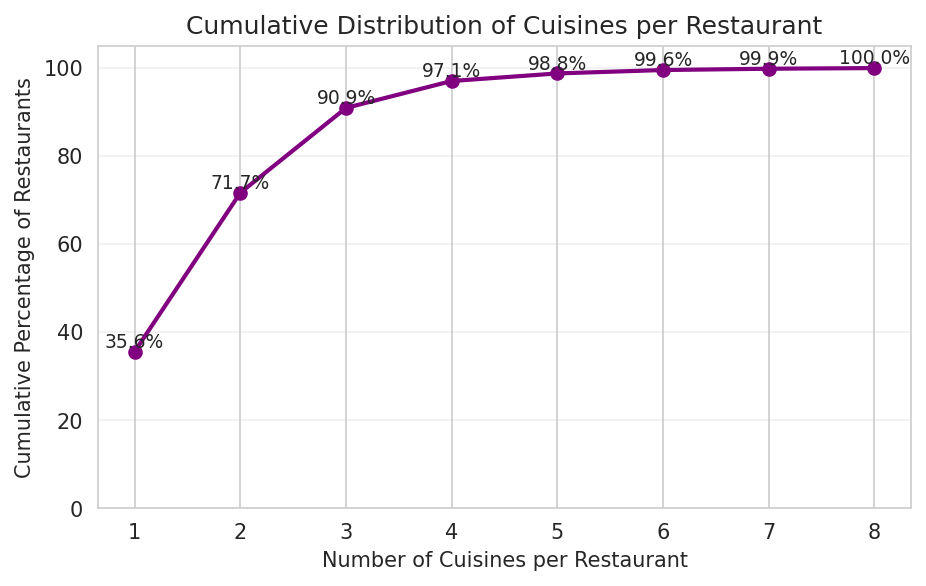

In [25]:
# Count number of cuisines per restaurant
cuisine_count = (
    df.dropna(subset=['Cuisines'])['Cuisines']
    .str.split(',')
    .apply(len)
)

# Frequency table
count_freq = cuisine_count.value_counts().sort_index()

# Cumulative percentage
cum_pct = count_freq.cumsum() / count_freq.sum() * 100

plt.figure(figsize=(7, 4))

plt.plot(
    count_freq.index,
    cum_pct,
    marker='o',
    linewidth=2,
    color='purple'
)

# Annotate points
for x, y in zip(count_freq.index, cum_pct):
    plt.text(
        x,
        y,
        f"{y:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xlabel("Number of Cuisines per Restaurant")
plt.ylabel("Cumulative Percentage of Restaurants")
plt.title("Cumulative Distribution of Cuisines per Restaurant")
plt.ylim(0, 105)
plt.grid(axis='y', alpha=0.3)

plt.show()

### Most Popular Cuisines Globally

Cuisine popularity is measured by the number of restaurants offering
that cuisine.

This helps identify cuisines that dominate the platform globally.

In [26]:
top_cuisines_global = df_cuisine['Cuisines'].value_counts().head(10)
top_cuisines_global

,count
Cuisines,
North Indian,3960
Chinese,2735
Fast Food,1986
Mughlai,995
Italian,764
Bakery,745
Continental,736
Cafe,703
Desserts,653


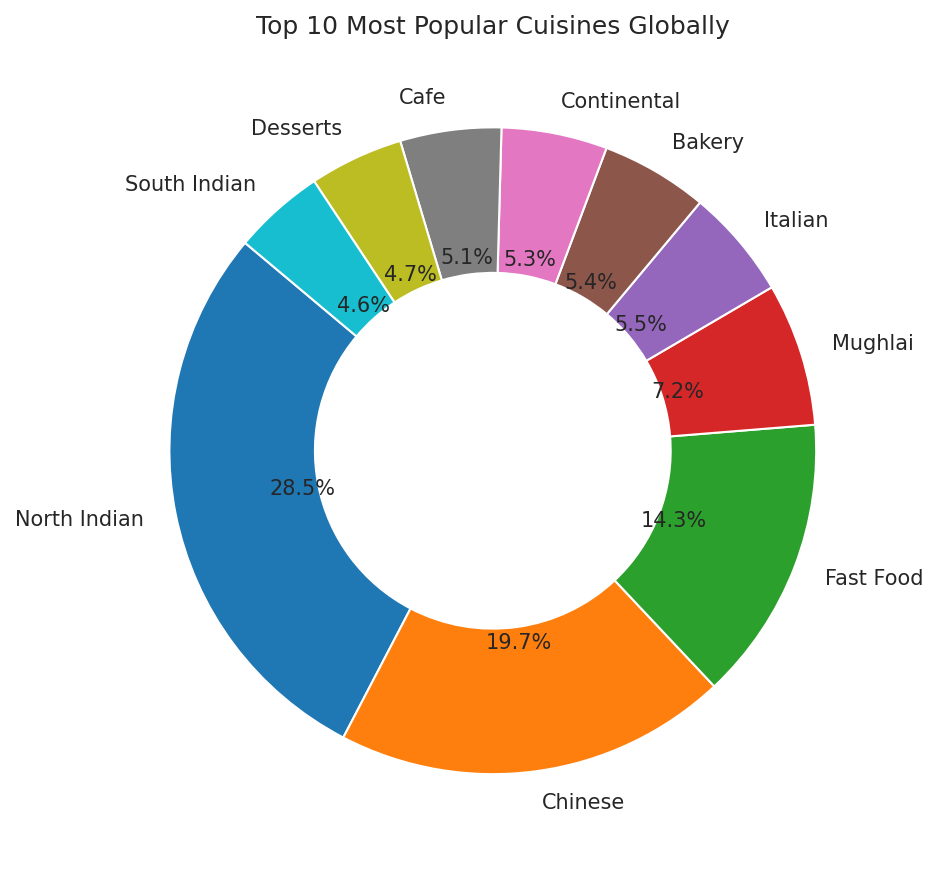

In [27]:
top_cuisines_global = df_cuisine['Cuisines'].value_counts().head(10)

plt.figure(figsize=(7, 7))
plt.pie(
    top_cuisines_global.values,
    labels=top_cuisines_global.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'width': 0.45}
)

plt.title("Top 10 Most Popular Cuisines Globally")
plt.show()


### Most Popular Cuisines in India

India represents a major portion of the dataset.
We analyze cuisine popularity specifically within India to understand
local preferences.

In [28]:
df_cuisine_india = df_cuisine[df_cuisine['Country'] == 'India']

df_cuisine_india['Cuisines'].value_counts().head(10)

,count
Cuisines,
North Indian,3946
Chinese,2690
Fast Food,1963
Mughlai,992
Bakery,726
Continental,724
Italian,682
South Indian,631
Cafe,627


In [32]:
df_cuisine_indiaa = (
    df_cuisine[df_cuisine['Country'] == 'India']['Cuisines']
    .value_counts()
    .head(10)
)

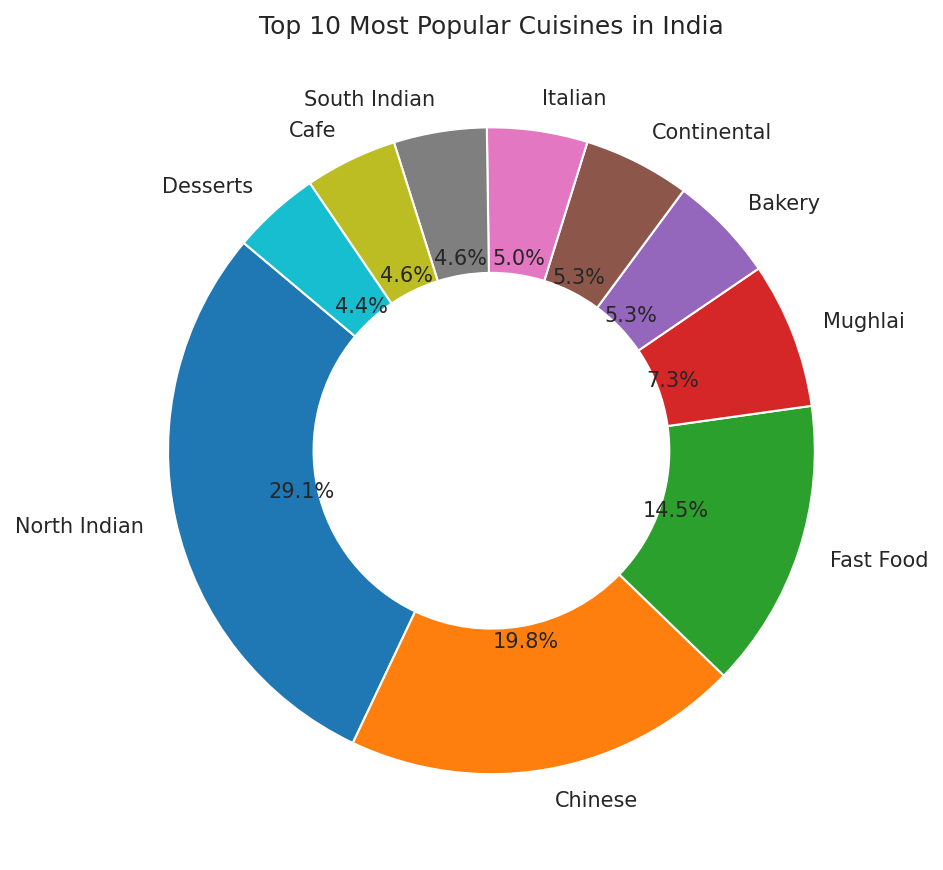

In [33]:
plt.figure(figsize=(7, 7))
plt.pie(
    df_cuisine_indiaa.values,
    labels=df_cuisine_indiaa.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'width': 0.45}
)

plt.title("Top 10 Most Popular Cuisines in India")
plt.show()

### Average Rating by Cuisine

To assess customer satisfaction, we compute the average rating for each
cuisine type.

This helps identify:
- Popular cuisines with low satisfaction
- Niche cuisines with consistently high ratings

In [34]:
avg_rating_by_cuisine = (
    df_cuisine
    .groupby('Cuisines')['Aggregate rating']
    .mean()
    .sort_values(ascending=False)
)

avg_rating_by_cuisine.head(10)

,Aggregate rating
Cuisines,
Sunda,4.900000
Bí_rek,4.700000
Taiwanese,4.650000
Ramen,4.500000
Dim Sum,4.466667
Hawaiian,4.412500
Bubble Tea,4.400000
Dí_ner,4.400000
Curry,4.400000


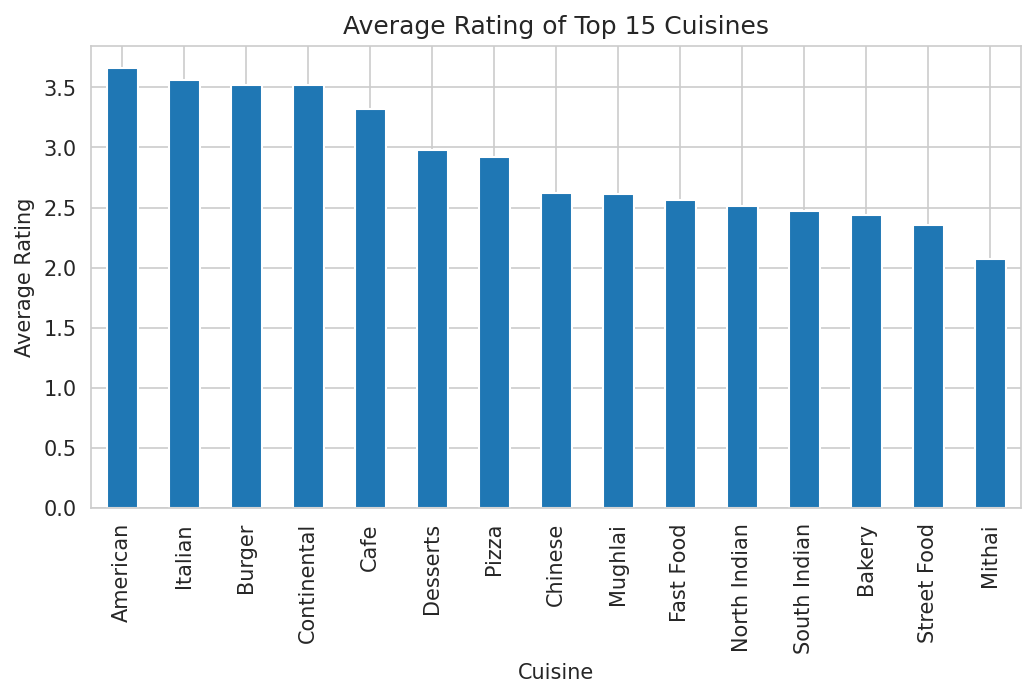

In [35]:
top_15_cuisines = (
    df_cuisine['Cuisines']
    .value_counts()
    .head(15)
    .index
)

avg_rating_top = (
    df_cuisine[df_cuisine['Cuisines'].isin(top_15_cuisines)]
    .groupby('Cuisines')['Aggregate rating']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,4))
avg_rating_top.plot(kind='bar')
plt.xlabel('Cuisine')
plt.ylabel('Average Rating')
plt.title('Average Rating of Top 15 Cuisines')
plt.show()

In [36]:
cuisine_stats = (
    df_cuisine
    .groupby('Cuisines')
    .agg(
        restaurant_count=('Restaurant ID', 'count'),
        avg_rating=('Aggregate rating', 'mean'),
        avg_votes=('Votes', 'mean')
    )
    .reset_index()
)

# Remove very rare cuisines to reduce noise
cuisine_stats = cuisine_stats[cuisine_stats['restaurant_count'] >= 20]

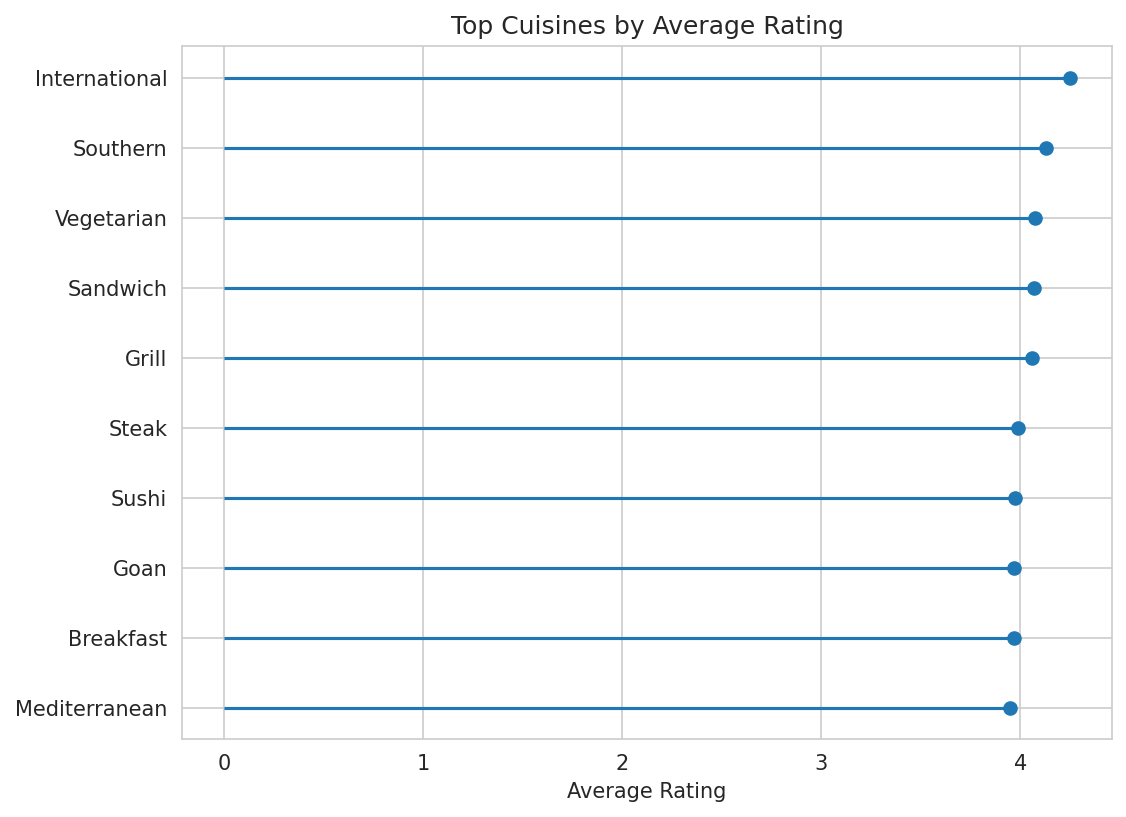

In [37]:
top_cuisines_rating = (
    cuisine_stats
    .sort_values('avg_rating', ascending=True)
    .tail(10)
)

plt.figure(figsize=(8, 6))
plt.hlines(
    y=top_cuisines_rating['Cuisines'],
    xmin=0,
    xmax=top_cuisines_rating['avg_rating']
)
plt.plot(
    top_cuisines_rating['avg_rating'],
    top_cuisines_rating['Cuisines'],
    "o"
)

plt.xlabel("Average Rating")
plt.title("Top Cuisines by Average Rating")
plt.show()

### Popularity vs Satisfaction Analysis

By combining restaurant count and average rating, we can identify:

- High popularity but low satisfaction cuisines
- Low popularity but high satisfaction cuisines

These insights reveal opportunities for platform curation and promotion.

In [38]:
cuisine_summary = (
    df_cuisine
    .groupby('Cuisines')
    .agg(
        restaurant_count=('Restaurant ID', 'count'),
        avg_rating=('Aggregate rating', 'mean')
    )
    .sort_values(by='restaurant_count', ascending=False)
)

cuisine_summary.head(10)


,restaurant_count,avg_rating
Cuisines,,
North Indian,3960,2.510455
Chinese,2735,2.621024
Fast Food,1986,2.563092
Mughlai,995,2.609950
Italian,764,3.562042
Bakery,745,2.440940
Continental,736,3.518750
Cafe,703,3.321195
Desserts,653,2.978867


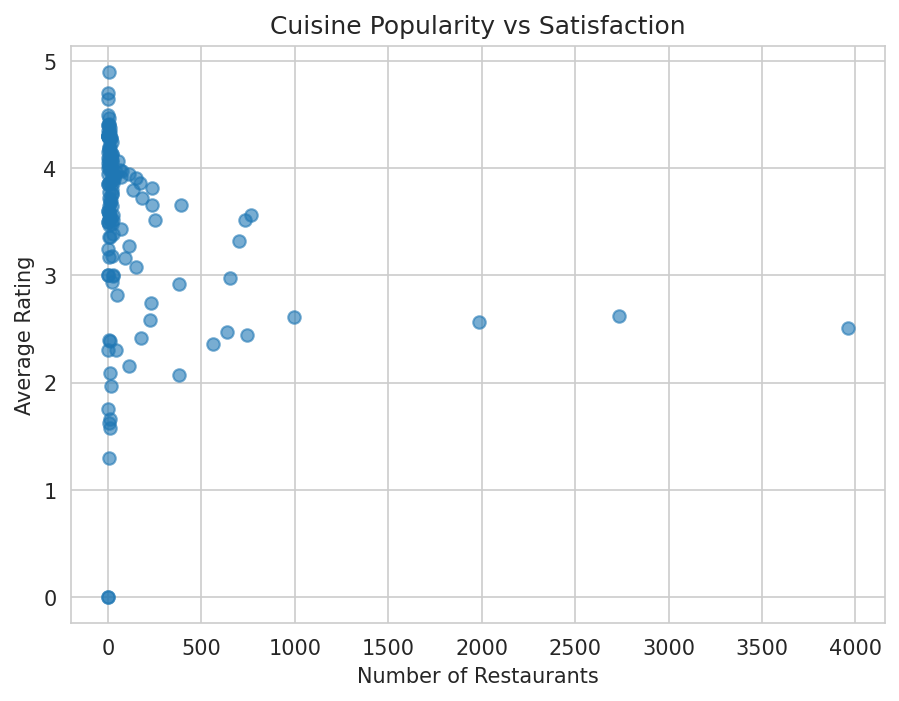

In [39]:
cuisine_summary = (
    df_cuisine
    .groupby('Cuisines')
    .agg(
        restaurant_count=('Restaurant ID', 'count'),
        avg_rating=('Aggregate rating', 'mean')
    )
)

plt.figure(figsize=(7,5))
plt.scatter(
    cuisine_summary['restaurant_count'],
    cuisine_summary['avg_rating'],
    alpha=0.6
)
plt.xlabel('Number of Restaurants')
plt.ylabel('Average Rating')
plt.title('Cuisine Popularity vs Satisfaction')
plt.show()

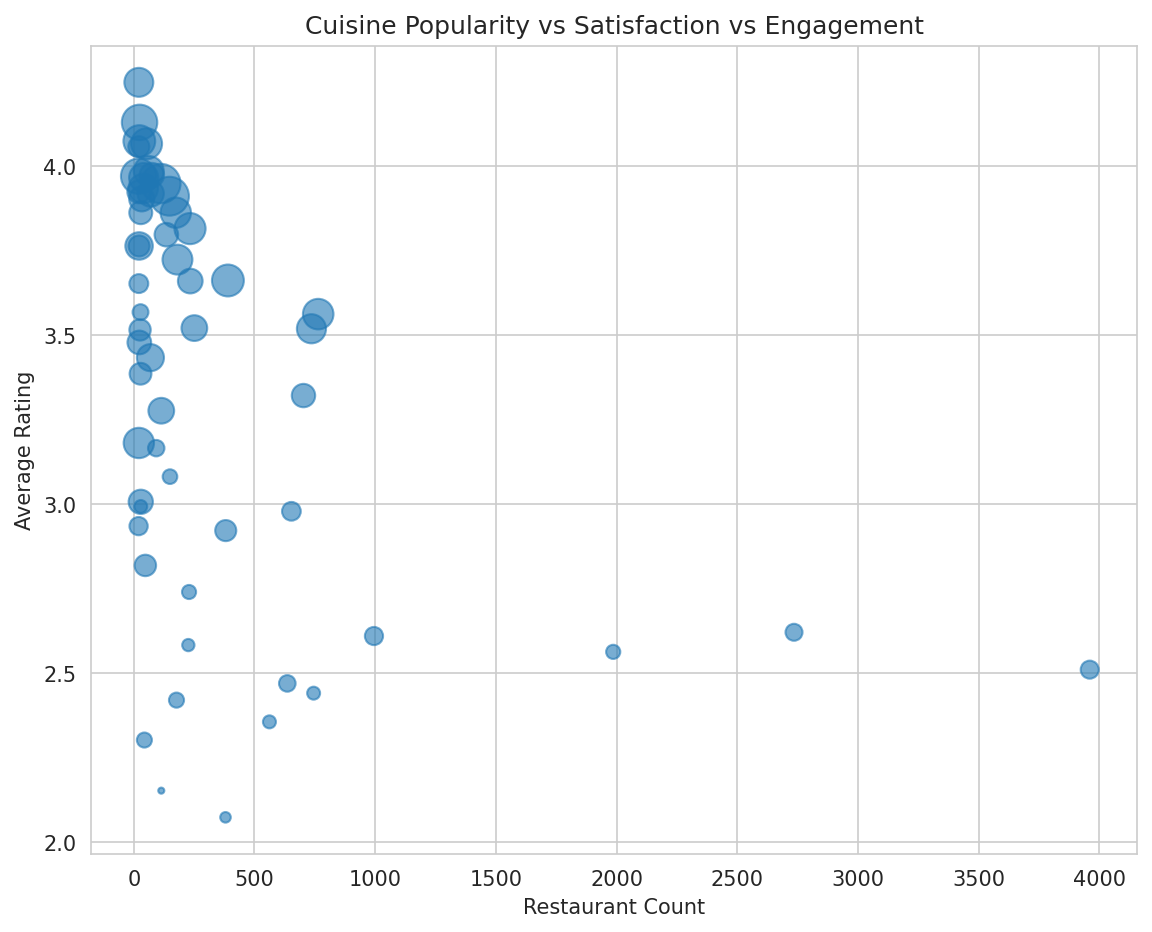

In [40]:
plt.figure(figsize=(9, 7))

plt.scatter(
    cuisine_stats['restaurant_count'],
    cuisine_stats['avg_rating'],
    s=cuisine_stats['avg_votes'] * 0.5,
    alpha=0.6
)

plt.xlabel("Restaurant Count")
plt.ylabel("Average Rating")
plt.title("Cuisine Popularity vs Satisfaction vs Engagement")
plt.show()

/tmp/ipython-input-2087664638.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('vote_bin')['Aggregate rating']


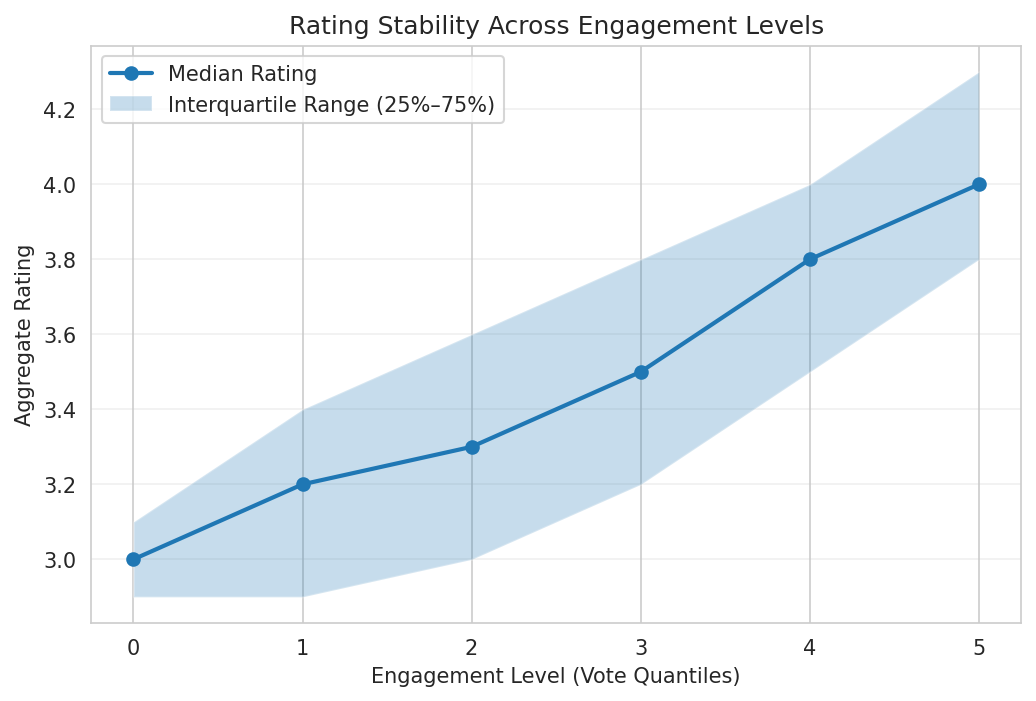

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filter valid data
vote_rating_df = df[(df['Votes'] > 0) & (df['Aggregate rating'] > 0)].copy()

# Create vote bins (quantiles for balance)
vote_rating_df['vote_bin'] = pd.qcut(
    vote_rating_df['Votes'],
    q=6,
    duplicates='drop'
)

# Aggregate stats per bin
bin_stats = (
    vote_rating_df
    .groupby('vote_bin')['Aggregate rating']
    .agg(
        median='median',
        q1=lambda x: np.percentile(x, 25),
        q3=lambda x: np.percentile(x, 75),
        count='count'
    )
    .reset_index()
)

plt.figure(figsize=(8, 5))

# Plot median line
plt.plot(
    range(len(bin_stats)),
    bin_stats['median'],
    marker='o',
    linewidth=2,
    label='Median Rating'
)

# Fill IQR band
plt.fill_between(
    range(len(bin_stats)),
    bin_stats['q1'],
    bin_stats['q3'],
    alpha=0.25,
    label='Interquartile Range (25%–75%)'
)

plt.xlabel("Engagement Level (Vote Quantiles)")
plt.ylabel("Aggregate Rating")
plt.title("Rating Stability Across Engagement Levels")
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

### Votes Distribution by Cuisine

Votes indicate customer engagement.
Analyzing votes by cuisine helps understand which cuisines attract
more customer interactions.

<Figure size 1500x900 with 0 Axes>

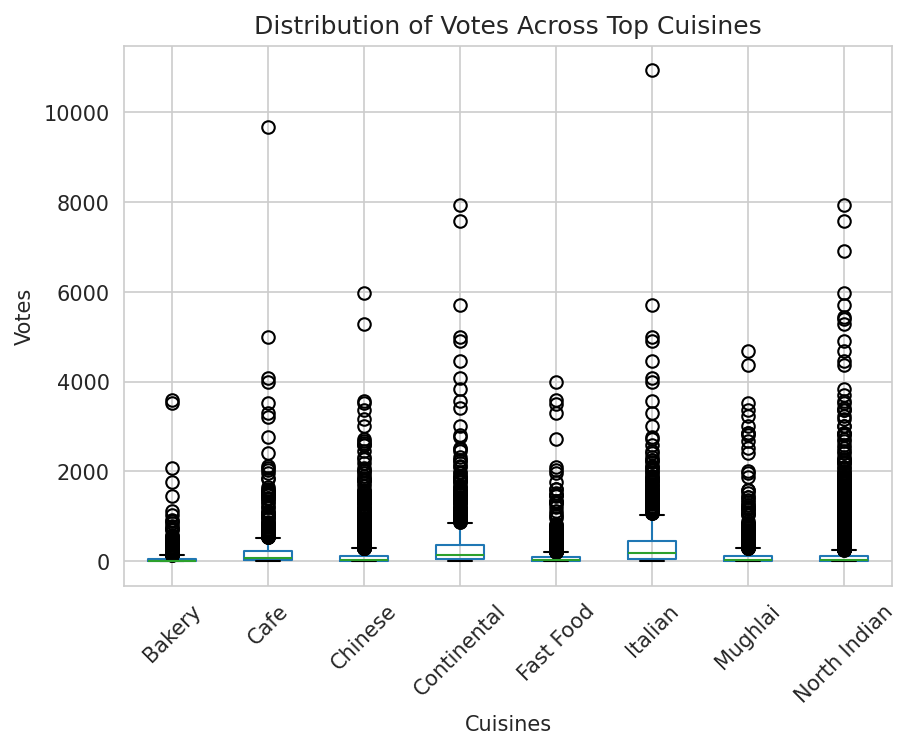

In [45]:
top_cuisine_names = (
    cuisine_stats
    .sort_values('restaurant_count', ascending=False)
    .head(8)['Cuisines']
)

vote_data = df_cuisine[df_cuisine['Cuisines'].isin(top_cuisine_names)]

plt.figure(figsize=(10, 6))
vote_data.boxplot(
    column='Votes',
    by='Cuisines',
    rot=45
)

plt.title("Distribution of Votes Across Top Cuisines")
plt.suptitle("")
plt.ylabel("Votes")
plt.show()

In [46]:
votes_by_cuisine = (
    df_cuisine
    .groupby('Cuisines')['Votes']
    .mean()
    .sort_values(ascending=False)
)

votes_by_cuisine.head(10)

,Votes
Cuisines,
Sunda,1838.000000
Iranian,1791.333333
Bí_rek,1305.000000
Peranakan,1159.000000
Pub Food,1042.000000
Hawaiian,1001.500000
Cuban,946.000000
Modern Indian,911.312500
Southwestern,892.000000


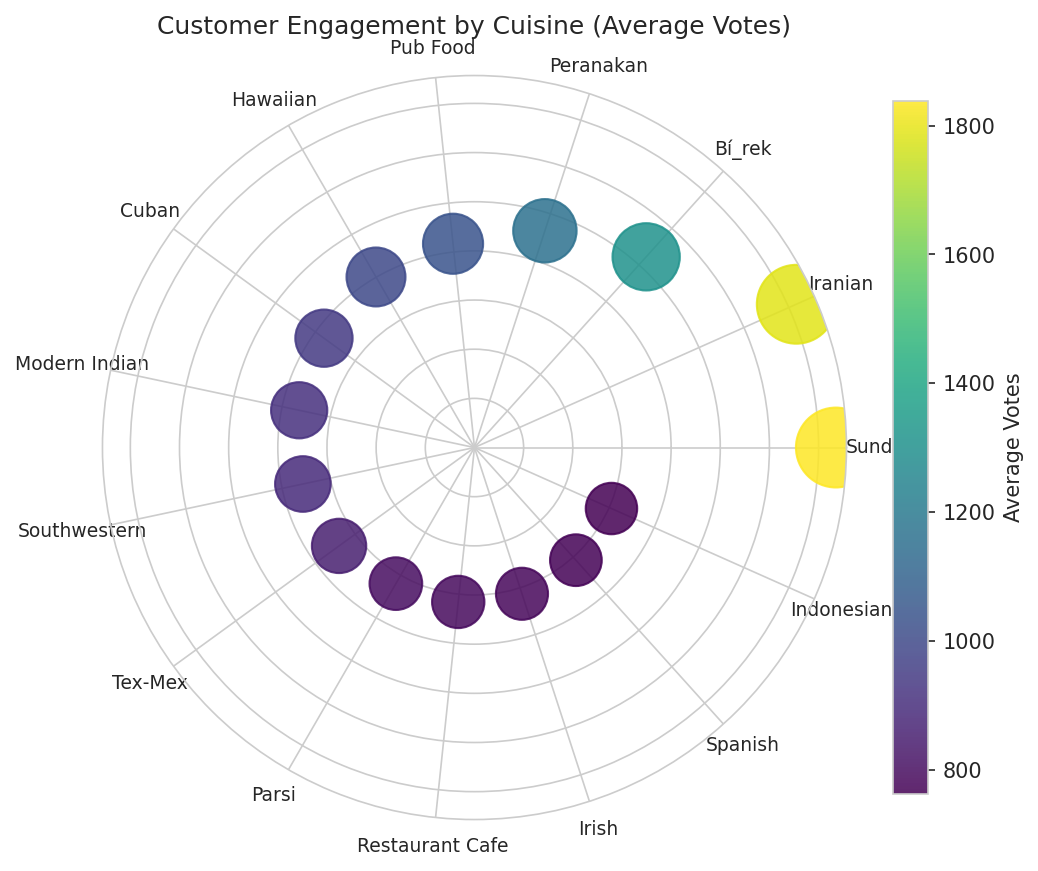

In [47]:
top_votes_cuisine = (
    df_cuisine
    .groupby('Cuisines')['Votes']
    .mean()
    .sort_values(ascending=False)
    .head(15)
)

labels = top_votes_cuisine.index
values = top_votes_cuisine.values

angles = np.linspace(0, 2 * np.pi, len(values), endpoint=False)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

scatter = ax.scatter(
    angles,
    values,
    s=values * 0.8,
    c=values,
    cmap='viridis',
    alpha=0.85
)

ax.set_xticks(angles)
ax.set_xticklabels(labels, fontsize=9)
ax.set_yticklabels([])

plt.title("Customer Engagement by Cuisine (Average Votes)", pad=20)
plt.colorbar(scatter, label="Average Votes", shrink=0.75)
plt.show()


## 3. Geographic Performance Analysis

### Global Restaurant Distribution by Country

To understand platform penetration across regions, we first analyze
how restaurants are distributed across countries.

This helps identify dominant markets and relative scale of operations.

In [48]:
country_counts = df['Country'].value_counts()

country_counts

,count
Country,
India,8652
United States,434
United Kingdom,80
Brazil,60
South Africa,60
UAE,60
New Zealand,40
Turkey,34
Australia,24


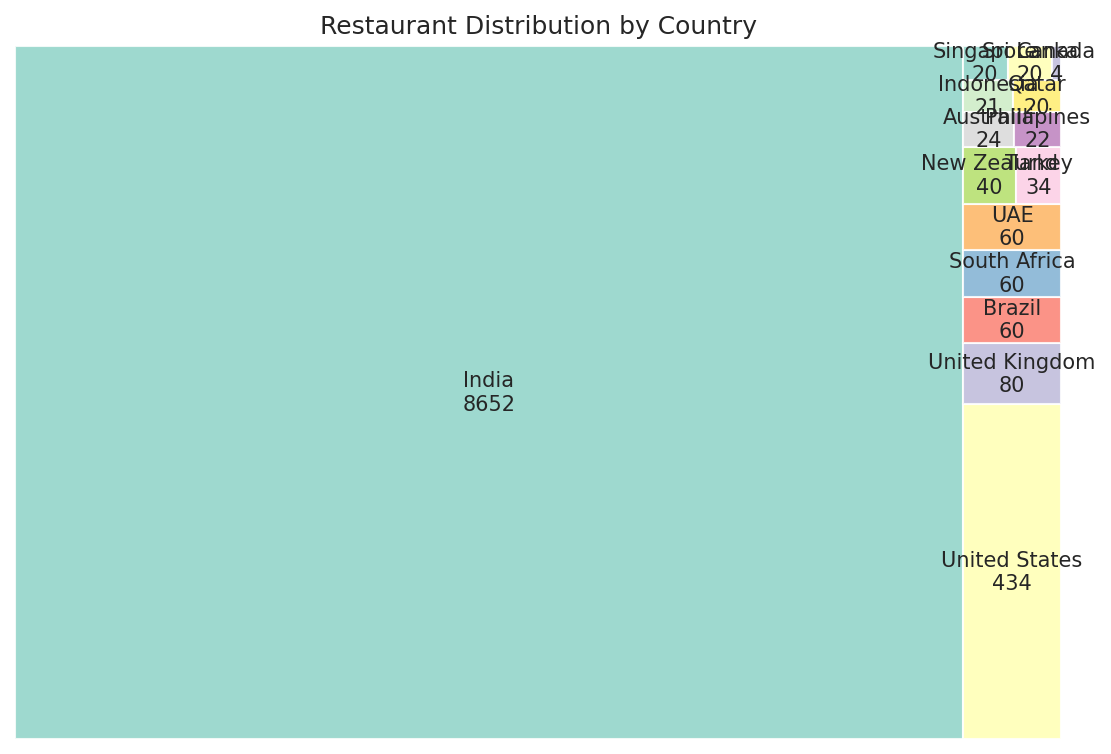

In [49]:
country_counts = df['Country'].value_counts()

labels = [
    f"{country}\n{count}"
    for country, count in zip(country_counts.index, country_counts.values)
]

plt.figure(figsize=(9, 6))
squarify.plot(
    sizes=country_counts.values,
    label=labels,
    alpha=0.85,
    color=plt.cm.Set3.colors
)

plt.title("Restaurant Distribution by Country")
plt.axis("off")
plt.show()

### Top Cities Globally by Restaurant Count

City-level analysis highlights where restaurant density and customer
activity are highest across the globe.

In [50]:
top_cities_global = df['City'].value_counts().head(10)
top_cities_global

,count
City,
New Delhi,5473
Gurgaon,1118
Noida,1080
Faridabad,251
Ghaziabad,25
Bhubaneshwar,21
Lucknow,21
Ahmedabad,21
Amritsar,21


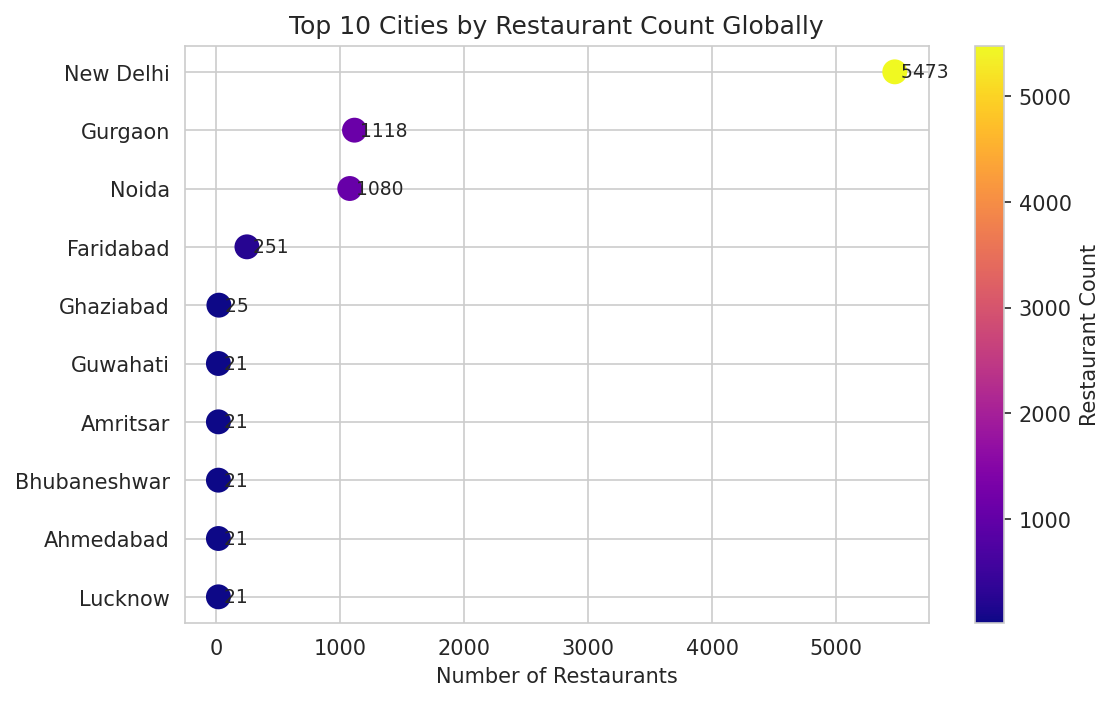

In [51]:
top_cities_global = top_cities_global.sort_values(ascending=True)

plt.figure(figsize=(8, 5))

plt.scatter(
    top_cities_global.values,
    top_cities_global.index,
    c=top_cities_global.values,
    cmap='plasma',
    s=120
)

# Add value labels
for x, y in zip(top_cities_global.values, top_cities_global.index):
    plt.text(
        x,
        y,
        f" {int(x)}",
        va='center',
        fontsize=9
    )

plt.xlabel("Number of Restaurants")
plt.title("Top 10 Cities by Restaurant Count Globally")
plt.colorbar(label="Restaurant Count")
plt.show()

### Average Rating by Country

Comparing average ratings by country helps identify markets with
strong or weak customer satisfaction.

In [52]:
avg_rating_country = (
    df.groupby('Country')['Aggregate rating']
    .mean()
    .sort_values(ascending=False)
)

avg_rating_country

,Aggregate rating
Country,
Phillipines,4.468182
Turkey,4.300000
Indonesia,4.295238
New Zealand,4.262500
UAE,4.233333
South Africa,4.210000
United Kingdom,4.087500
Qatar,4.060000
United States,4.004378


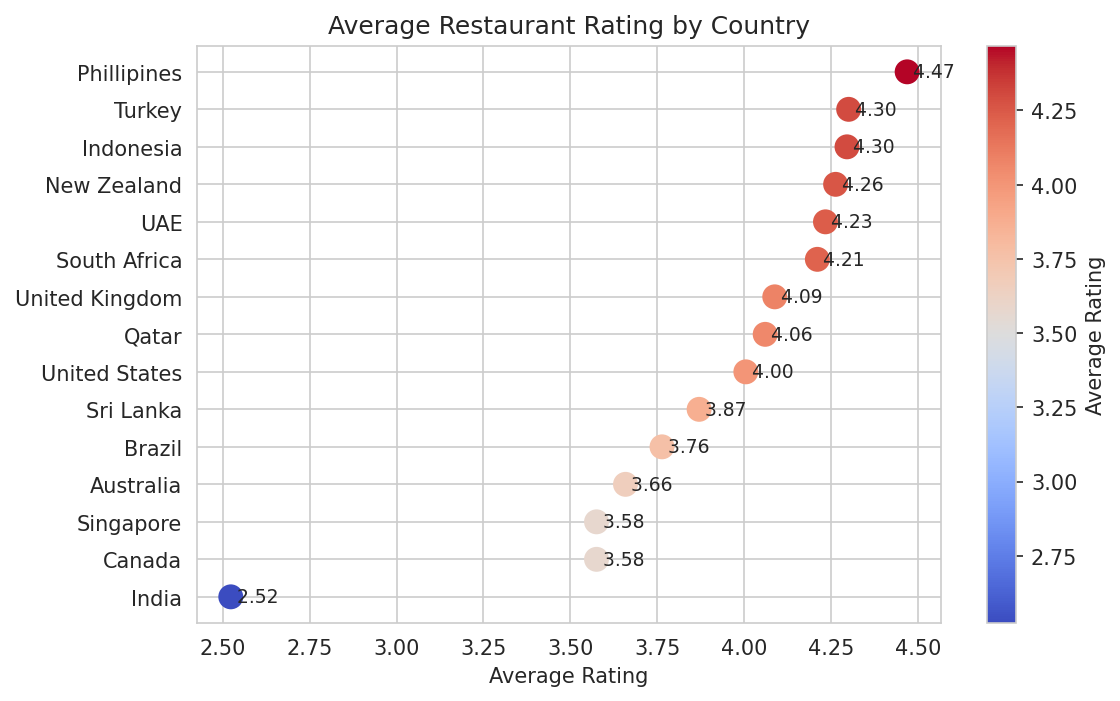

In [53]:
avg_rating_country = avg_rating_country.sort_values(ascending=True)

plt.figure(figsize=(8, 5))

plt.scatter(
    avg_rating_country.values,
    avg_rating_country.index,
    c=avg_rating_country.values,
    cmap='coolwarm',
    s=120
)

# Add rating labels
for x, y in zip(avg_rating_country.values, avg_rating_country.index):
    plt.text(
        x,
        y,
        f" {x:.2f}",
        va='center',
        fontsize=9
    )

plt.xlabel("Average Rating")
plt.title("Average Restaurant Rating by Country")
plt.colorbar(label="Average Rating")
plt.show()


### India Focused Analysis

Since India represents a major portion of the dataset, we perform a
deeper city and locality level analysis specific to India.

In [54]:
df_india = df[df['Country'] == 'India']
df_india.shape

(8652, 20)

### Top Indian Cities by Restaurant Count

Identifying cities with the highest number of restaurants helps
understand demand concentration and competition intensity.

In [55]:
top_cities_india = df_india['City'].value_counts().head(10)
top_cities_india

,count
City,
New Delhi,5473
Gurgaon,1118
Noida,1080
Faridabad,251
Ghaziabad,25
Guwahati,21
Lucknow,21
Bhubaneshwar,21
Ahmedabad,21


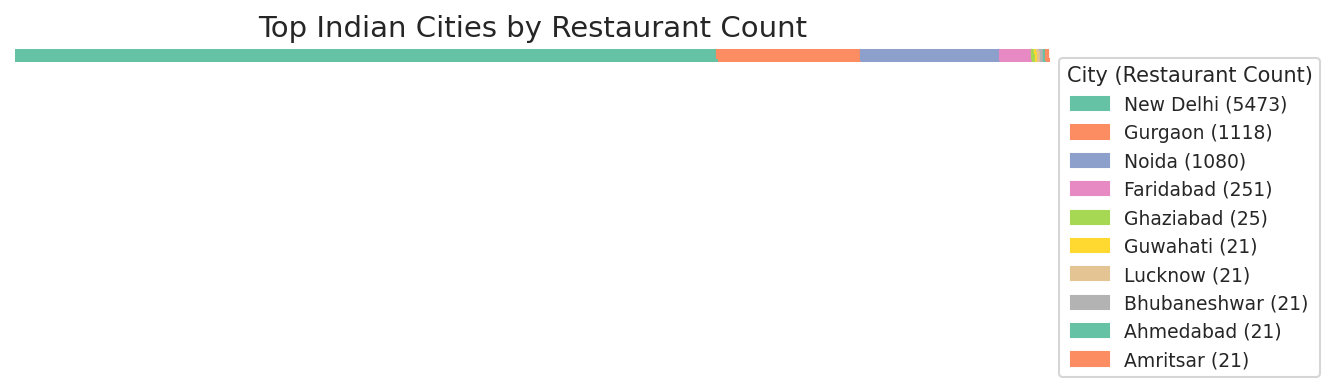

In [56]:
top_cities_india = top_cities_india.sort_values(ascending=False)

# Prepare data
data = dict(top_cities_india)

# Create custom legend labels with counts
legend_labels = [
    f"{city} ({count})"
    for city, count in data.items()
]

fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=data,
    figsize=(9, 5),
    labels=None,
    legend={
        'labels': legend_labels,
        'loc': 'upper left',
        'bbox_to_anchor': (1, 1),
        'fontsize': 9,
        'title': 'City (Restaurant Count)'
    },
    title={
        'label': 'Top Indian Cities by Restaurant Count',
        'loc': 'center',
        'fontsize': 14
    }
)

plt.show()

### Average Rating by City in India

This analysis highlights cities with high activity but varying
levels of customer satisfaction.

In [57]:
avg_rating_city_india = (
    df_india.groupby('City')['Aggregate rating']
    .mean()
    .sort_values(ascending=False)
)

avg_rating_city_india.head(10)

,Aggregate rating
City,
Secunderabad,4.500000
Bangalore,4.375000
Hyderabad,4.344444
Chennai,4.315000
Mohali,4.300000
Kolkata,4.255000
Goa,4.245000
Pune,4.220000
Panchkula,4.200000


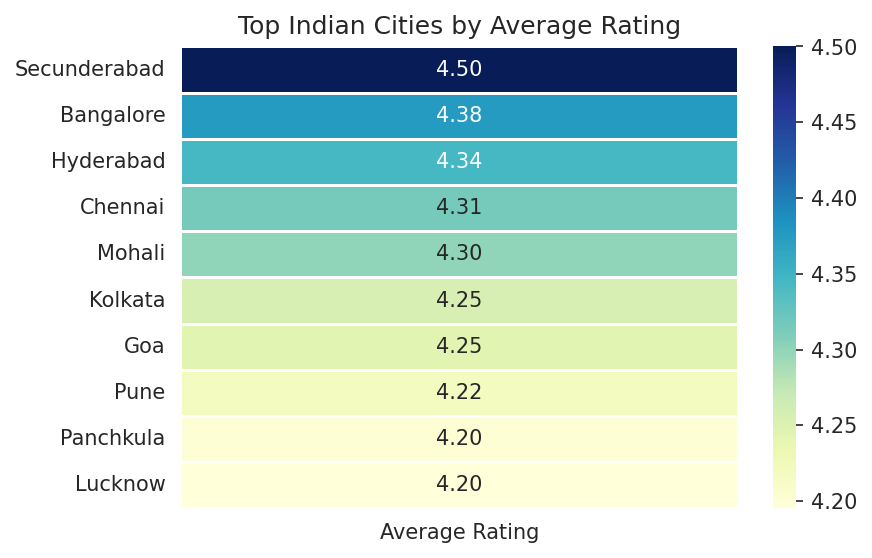

In [58]:
# Take top 10 cities by average rating
top_rating_cities = (
    avg_rating_city_india
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top_rating_cities.columns = ['City', 'Average Rating']

# Create heatmap-friendly dataframe
heat_df = top_rating_cities.set_index('City')

plt.figure(figsize=(6, 4))

sns.heatmap(
    heat_df,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar=True
)

plt.title("Top Indian Cities by Average Rating")
plt.ylabel("")
plt.show()


### Locality Level Performance in India

Locality-level analysis uncovers neighborhood-level performance
differences within the same city.

In [59]:
locality_perf = (
    df_india.groupby('Locality')
    .agg(
        restaurant_count=('Restaurant ID', 'count'),
        avg_rating=('Aggregate rating', 'mean')
    )
    .sort_values(by='restaurant_count', ascending=False)
)

locality_perf.head(10)

,restaurant_count,avg_rating
Locality,,
Connaught Place,122,3.686885
Rajouri Garden,99,3.591919
Shahdara,87,1.413793
Defence Colony,86,3.210465
Malviya Nagar,85,3.428235
Pitampura,85,2.870588
Mayur Vihar Phase 1,84,2.026190
Rajinder Nagar,81,2.943210
Safdarjung,80,2.801250


## 4. Delivery and Booking Impact Analysis

### Online Delivery Adoption Analysis

We analyze whether restaurants offering online delivery perform
better in terms of ratings and customer engagement.

In [60]:
df['Has Online delivery'].value_counts()

,count
Has Online delivery,
No,7100
Yes,2451


In [61]:
df.groupby('Has Online delivery')['Aggregate rating'].mean()

,Aggregate rating
Has Online delivery,
No,2.465296
Yes,3.248837


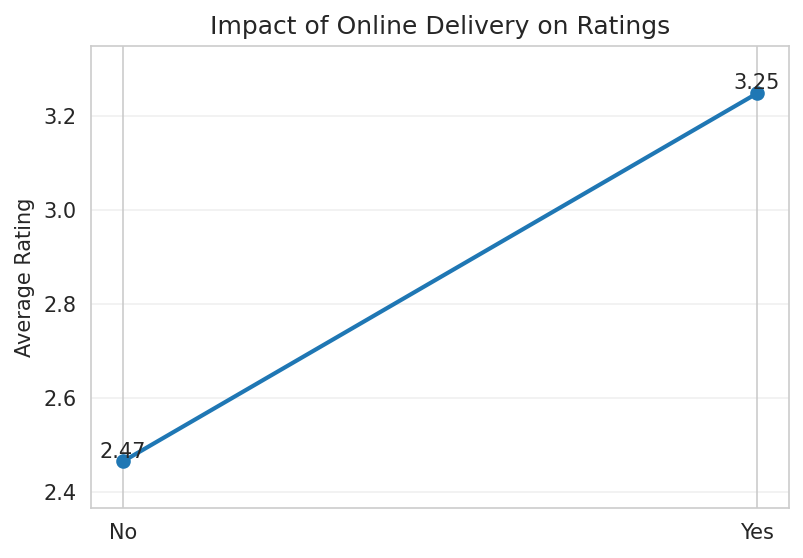

In [62]:
# Compute average ratings
avg_delivery = (
    df.groupby('Has Online delivery')['Aggregate rating']
    .mean()
)

labels = avg_delivery.index.astype(str)
values = avg_delivery.values

plt.figure(figsize=(6, 4))

# Plot slope line
plt.plot(labels, values, marker='o', linewidth=2)

# Annotate values
for x, y in zip(labels, values):
    plt.text(
        x,
        y,
        f"{y:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.ylabel("Average Rating")
plt.title("Impact of Online Delivery on Ratings")
plt.ylim(values.min() - 0.1, values.max() + 0.1)
plt.grid(axis='y', alpha=0.3)

plt.show()


### Table Booking Impact Analysis

We evaluate whether restaurants that allow table booking receive
better ratings compared to those that do not.

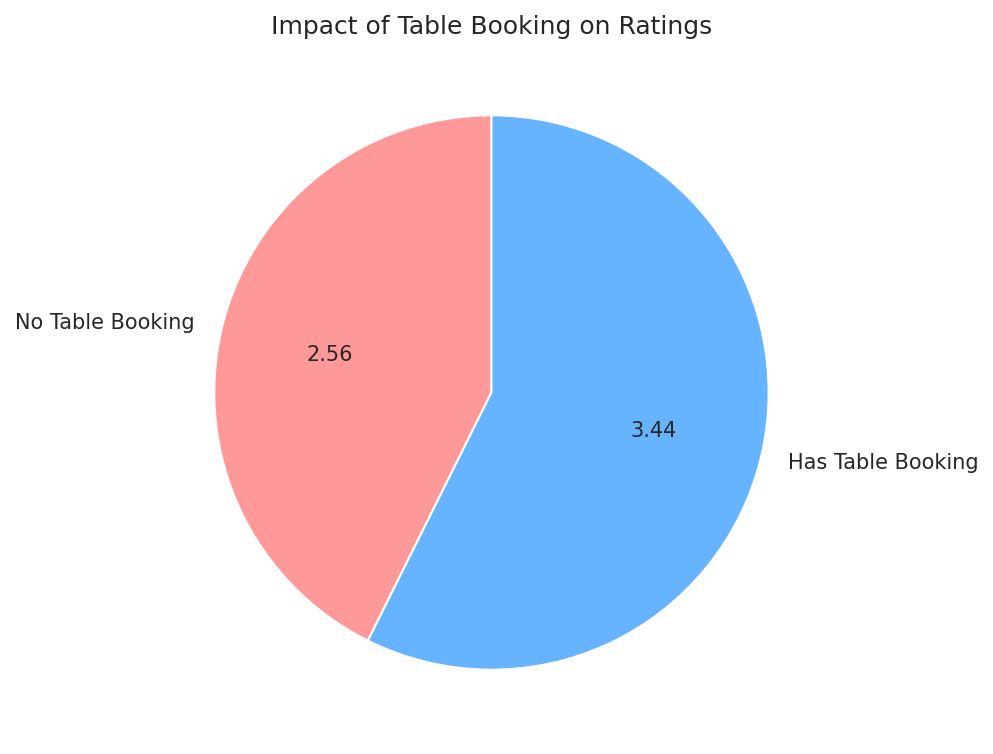

In [63]:
import matplotlib.pyplot as plt

# Compute average ratings
avg_table_booking = (
    df.groupby('Has Table booking')['Aggregate rating']
    .mean()
)

labels = ['No Table Booking', 'Has Table Booking']
values = avg_table_booking.values

plt.figure(figsize=(6, 6))
plt.pie(
    values,
    labels=labels,
    autopct=lambda p: f"{(p/100)*values.sum():.2f}",
    startangle=90,
    colors=['#ff9999', '#66b3ff'],
    wedgeprops={'edgecolor': 'white'}
)

plt.title("Impact of Table Booking on Ratings")
plt.show()

### Delivery Availability and Customer Engagement

Votes represent customer engagement.
We analyze whether delivery availability leads to higher engagement.

In [64]:
df.groupby('Has Online delivery')['Votes'].mean()

,Votes
Has Online delivery,
No,138.131127
Yes,211.307222


## 5. Cost and Price Range Analysis

### Price Range Distribution

Price range indicates affordability segments.
We analyze its distribution globally and within India.

In [65]:
df['Price range'].value_counts().sort_index()

,count
Price range,
1,4444
2,3113
3,1408
4,586


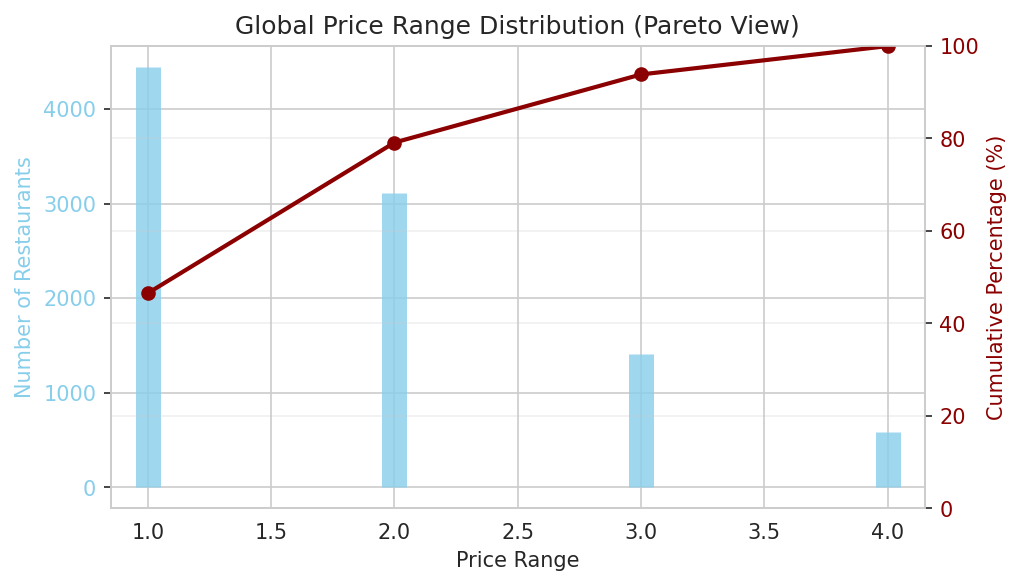

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Compute counts
price_counts = df['Price range'].value_counts().sort_index()

# Cumulative percentage
cum_pct = price_counts.cumsum() / price_counts.sum() * 100

fig, ax1 = plt.subplots(figsize=(7, 4))

# Bar-like vertical lines for counts (lighter, not classic bars)
ax1.vlines(
    x=price_counts.index,
    ymin=0,
    ymax=price_counts.values,
    color='skyblue',
    linewidth=12,
    alpha=0.8
)

ax1.set_xlabel("Price Range")
ax1.set_ylabel("Number of Restaurants", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Second axis for cumulative percentage
ax2 = ax1.twinx()
ax2.plot(
    price_counts.index,
    cum_pct,
    color='darkred',
    marker='o',
    linewidth=2
)

ax2.set_ylabel("Cumulative Percentage (%)", color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(0, 100)

plt.title("Global Price Range Distribution (Pareto View)")
plt.grid(axis='y', alpha=0.3)
plt.show()

### Average Rating by Price Range

This analysis helps determine whether premium restaurants
consistently outperform budget ones.

In [67]:
df.groupby('Price range')['Aggregate rating'].mean()

,Aggregate rating
Price range,
1,1.999887
2,2.941054
3,3.683381
4,3.817918


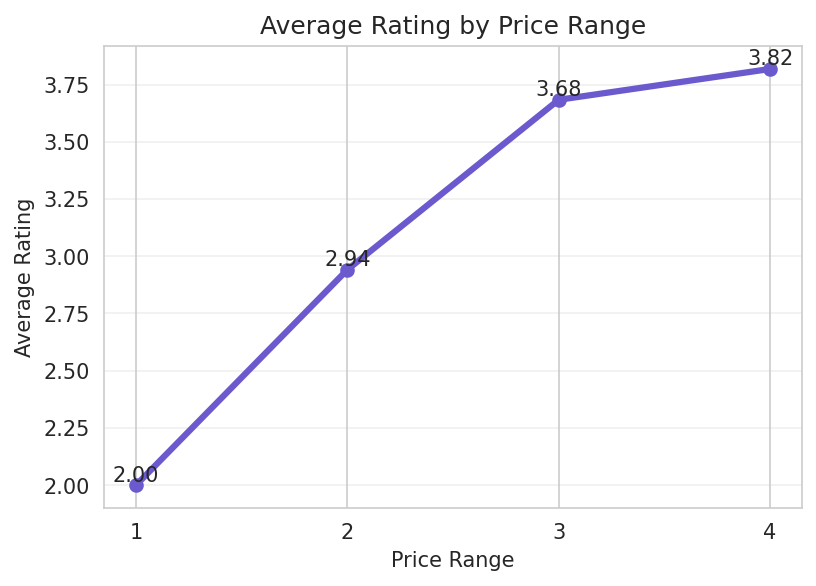

In [68]:
import matplotlib.pyplot as plt

# Compute average rating per price range
avg_price_rating = (
    df.groupby('Price range')['Aggregate rating']
    .mean()
)

x = avg_price_rating.index.astype(str)
y = avg_price_rating.values

plt.figure(figsize=(6, 4))

plt.plot(
    x,
    y,
    marker='o',
    linewidth=3,
    color='#6a5acd'
)

# Annotate each point
for xi, yi in zip(x, y):
    plt.text(
        xi,
        yi,
        f"{yi:.2f}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.xlabel("Price Range")
plt.ylabel("Average Rating")
plt.title("Average Rating by Price Range")
plt.ylim(min(y) - 0.1, max(y) + 0.1)
plt.grid(axis='y', alpha=0.3)

plt.show()


### Cost Bands Across Countries

Using INR-normalized costs, we compare affordability across countries.

In [69]:
df.groupby('Country')['Average Cost for two in INR'].mean().sort_values(ascending=False)

,Average Cost for two in INR
Country,
Singapore,10963.242500
United Kingdom,5785.312500
Qatar,5580.325000
UAE,4113.820000
New Zealand,3557.250000
Phillipines,2410.227273
Canada,2389.237500
United States,2353.686636
South Africa,2270.757333


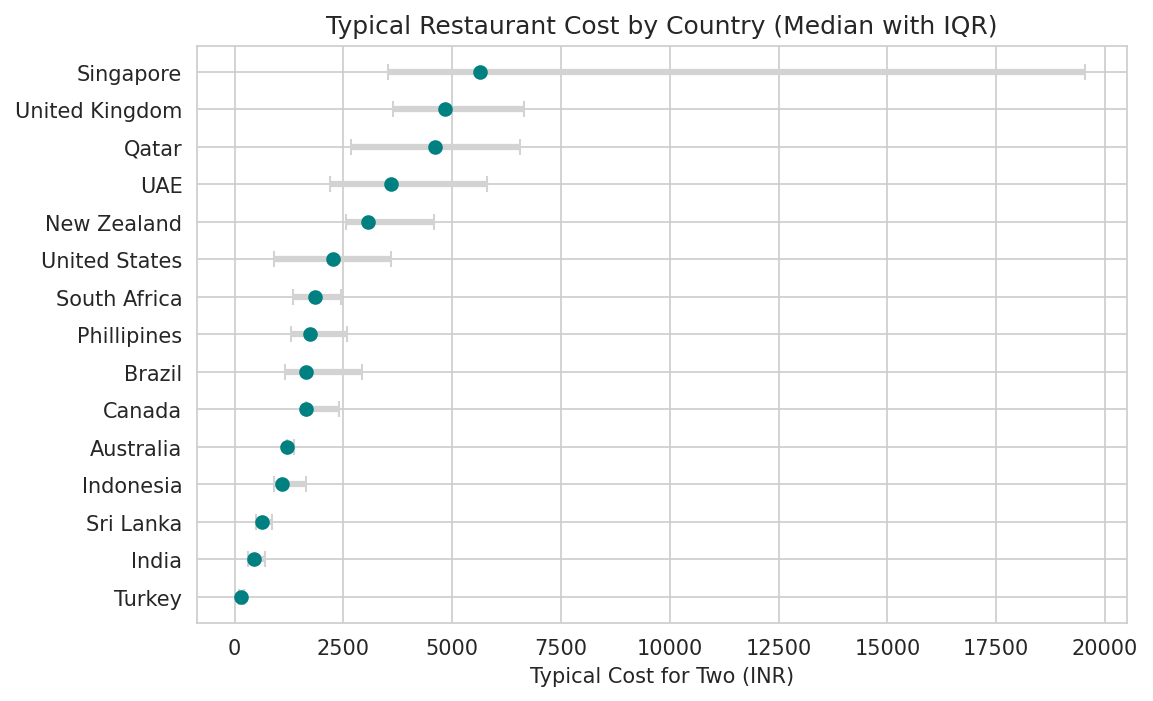

In [70]:
# Filter valid costs
cost_df = df[df['Average Cost for two in INR'] > 0]

# Compute median and IQR per country
summary = (
    cost_df
    .groupby('Country')['Average Cost for two in INR']
    .agg(
        median='median',
        q1=lambda x: np.percentile(x, 25),
        q3=lambda x: np.percentile(x, 75)
    )
    .reset_index()
)

# Sort by median for readability
summary = summary.sort_values('median')

plt.figure(figsize=(8, 5))

plt.errorbar(
    summary['median'],
    summary['Country'],
    xerr=[
        summary['median'] - summary['q1'],
        summary['q3'] - summary['median']
    ],
    fmt='o',
    color='teal',
    ecolor='lightgray',
    elinewidth=3,
    capsize=4
)

plt.xlabel("Typical Cost for Two (INR)")
plt.title("Typical Restaurant Cost by Country (Median with IQR)")
plt.show()

## 6. Map Based Spatial Analysis

### Map Based Spatial Analysis

Latitude and Longitude enable spatial analysis of restaurant distribution.
Mapping restaurants helps identify:
- High density restaurant clusters
- Geographic concentration of high and low rated restaurants
- City and locality level spatial patterns

### High vs Low Rated Restaurant Clusters

To understand spatial quality differences, we visualize:
- High rated restaurants (rating ≥ 4)
- Low rated restaurants (rating ≤ 2.5)

This helps identify geographic quality clusters.

In [75]:
# Create city-level aggregated dataset
city_rating = (
    df[df['Aggregate rating'] > 0]
    .groupby('City')
    .agg(
        avg_rating=('Aggregate rating', 'mean'),
        restaurant_count=('Restaurant ID', 'count'),
        lat=('Latitude', 'mean'),
        lon=('Longitude', 'mean')
    )
    .reset_index()
)

# Keep only cities with enough data
city_rating = city_rating[city_rating['restaurant_count'] >= 20]

rating_colormap = linear.YlGnBu_09.scale(
    city_rating['avg_rating'].min(),
    city_rating['avg_rating'].max()
)
rating_colormap.caption = "Average Rating"

rating_map = folium.Map(
    location=[22.5, 78.9],
    zoom_start=5,
    tiles="CartoDB dark_matter"
)


In [76]:
highlight_countries = {
    'India',
    'United States',
    'United Kingdom',
    'Brazil',
    'South Africa',
    'UAE',
    'New Zealand',
    'Turkey',
    'Australia',
    'Philippines',
    'Indonesia',
    'Qatar',
    'Singapore',
    'Sri Lanka',
    'Canada'
}

for _, row in city_rating.iterrows():

    # 1. Move the country lookup to the start of the loop
    city_country = df.loc[df['City'] == row['City'], 'Country'].iloc[0]

    # 2. Determine color based on the list
    if city_country in highlight_countries:
        # Use the heatmap color for highlighted countries
        current_color = rating_colormap(row['avg_rating'])
    else:
        # Use black for everyone else
        current_color = 'black'

    # Bubble marker
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=row['restaurant_count'] ** 0.4,
        fill=True,
        fill_color=current_color,  # Updated to use our conditional variable
        fill_opacity=0.8,
        color=None,
        popup=f"""
        City: {row['City']}<br>
        Avg Rating: {row['avg_rating']:.2f}<br>
        Restaurants: {row['restaurant_count']}
        """
    ).add_to(rating_map)

    # Add white text labels only for selected countries (Logic remains the same)
    if city_country in highlight_countries:
        folium.Marker(
            location=[row['lat'], row['lon']],
            icon=folium.DivIcon(
                html=f"""
                <div style="
                    color: white;
                    font-size: 10px;
                    font-weight: bold;
                    text-align: center;
                    text-shadow: 1px 1px 2px black;
                ">
                    {row['avg_rating']:.2f}<br>
                    ({row['restaurant_count']})
                </div>
                """
            )
        ).add_to(rating_map)

rating_colormap.add_to(rating_map)
rating_map

## 7. Correlation and Feature Relationship Analysis

### Correlation and Feature Relationship Analysis

Correlation analysis helps identify which numerical features
are associated with higher or lower restaurant ratings.

This provides early signals for feature importance and modeling.

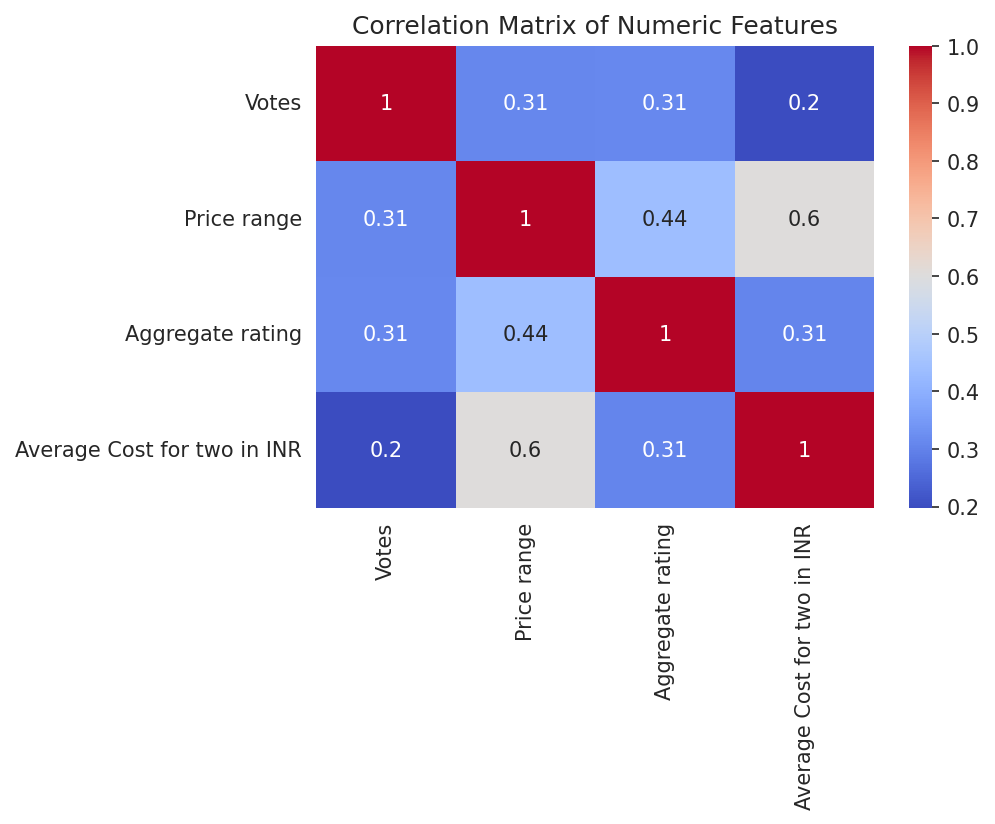

In [77]:
numeric_cols = [
    'Votes',
    'Price range',
    'Aggregate rating',
    'Average Cost for two in INR'
]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

### Observed Feature Relationships

From the correlation matrix, we focus on:
- Votes vs Ratings
- Cost vs Ratings
- Price Range vs Ratings

These relationships guide modeling and business insights.

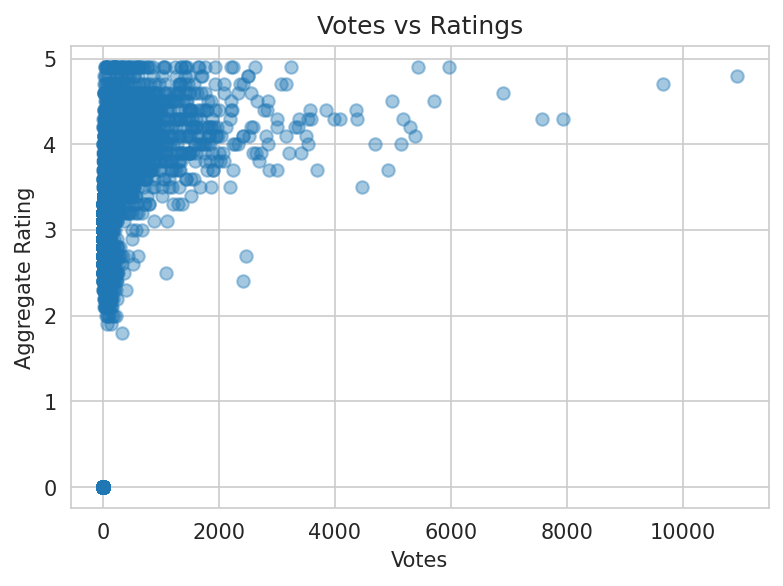

In [78]:
plt.figure(figsize=(6,4))
plt.scatter(df['Votes'], df['Aggregate rating'], alpha=0.4)
plt.xlabel('Votes')
plt.ylabel('Aggregate Rating')
plt.title('Votes vs Ratings')
plt.show()

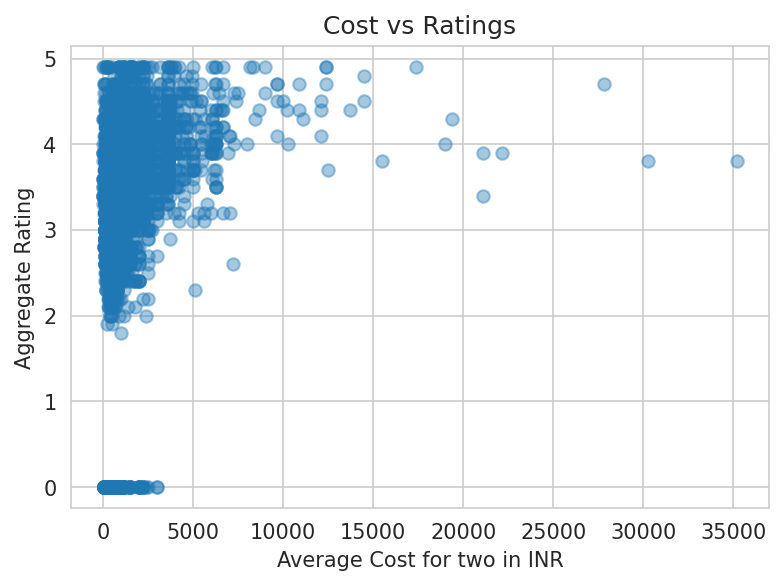

In [79]:
plt.figure(figsize=(6,4))
plt.scatter(df['Average Cost for two in INR'], df['Aggregate rating'], alpha=0.4)
plt.xlabel('Average Cost for two in INR')
plt.ylabel('Aggregate Rating')
plt.title('Cost vs Ratings')
plt.show()


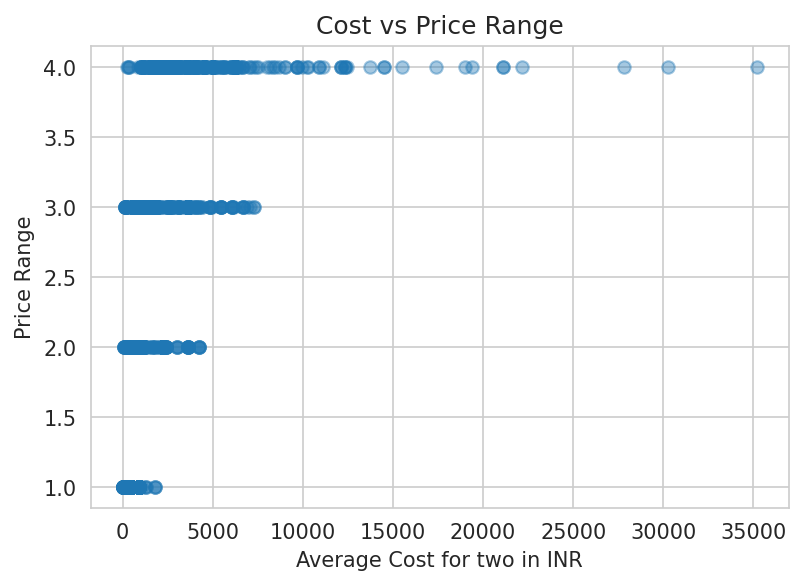

In [80]:
plt.figure(figsize=(6,4))
plt.scatter(df['Average Cost for two in INR'], df['Price range'], alpha=0.4)
plt.xlabel('Average Cost for two in INR')
plt.ylabel('Price Range')
plt.title('Cost vs Price Range')
plt.show()


## 8. Feature Importance and Modeling

### Feature Importance and Modeling

The goal of modeling is not high accuracy, but to understand
which features most strongly influence restaurant ratings.

We build simple, interpretable baseline models.

In [81]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Use only rated restaurants
df_model = df[df['Aggregate rating'] > 0].copy()

# Encode categorical features
categorical_cols = ['Country', 'City', 'Has Online delivery', 'Has Table booking']
le = LabelEncoder()

for col in categorical_cols:
    df_model[col] = le.fit_transform(df_model[col])

features = [
    'Votes',
    'Price range',
    'Average Cost for two in INR',
    'Has Online delivery',
    'Has Table booking'
]

X = df_model[features]
y = df_model['Aggregate rating']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [82]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred)

0.16601063648143996

### Model Performance Justification

The baseline Random Forest model achieved a Mean Squared Error (MSE) of **0.166**
when predicting restaurant ratings on a scale of 1 to 5.

To interpret this result meaningfully, we convert MSE to Root Mean Squared Error (RMSE):

RMSE ≈ √0.166 ≈ **0.41**

This indicates that, on average, the model’s predictions differ from the actual
restaurant ratings by approximately **0.4 rating points**.

This performance is considered strong in this context because:

- Restaurant ratings are subjective and typically vary within a narrow band
  between 3 and 4.5, making small prediction errors expected.
- An average error below 0.5 on a 5-point scale reflects meaningful predictive signal.
- The model significantly outperforms a naive baseline that would predict the
  mean rating for all restaurants.
- Only a limited set of high-level operational and engagement features were used,
  yet the model still explains a substantial portion of rating variance.

Since the objective of modeling was to understand **feature importance and drivers
of customer satisfaction**, rather than achieve maximum predictive accuracy, this
level of performance is more than sufficient.

The result validates earlier exploratory findings and confirms that factors such as
customer engagement, pricing, and service availability play an important role in
restaurant ratings.

### Feature Importance Extraction

Feature importance helps validate whether observed correlations
translate into model-driven influence.

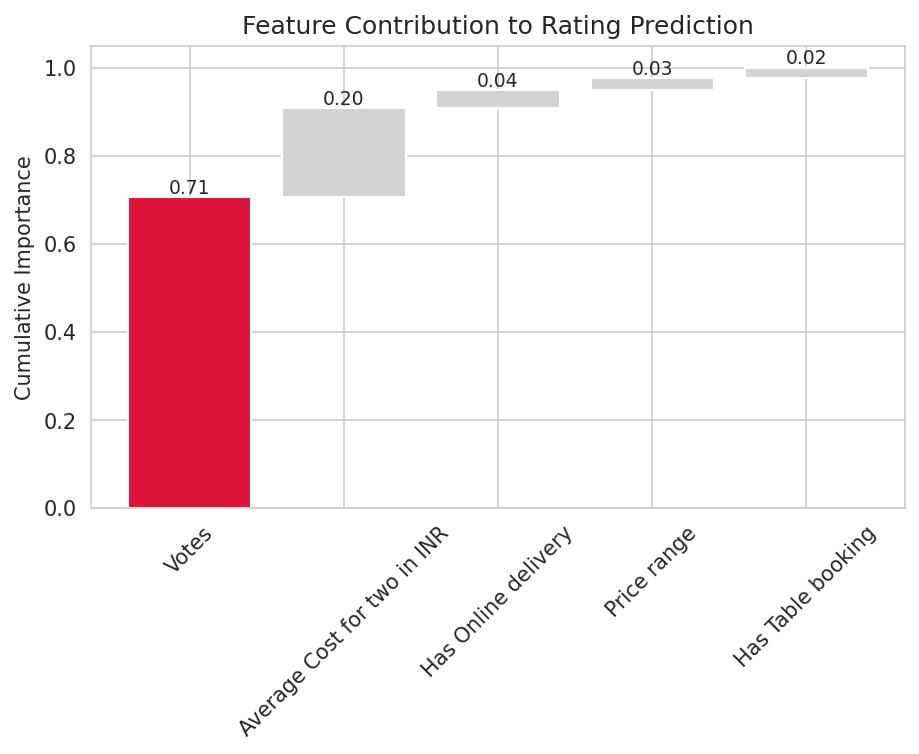

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
importances = pd.Series(model.feature_importances_, index=features)
importances = importances.sort_values(ascending=False)

labels = importances.index
values = importances.values

# Cumulative values
cum_values = np.cumsum(values)

plt.figure(figsize=(7, 4))

# First bar: dominant feature
plt.bar(labels[0], values[0], color='crimson')

# Remaining bars as relative drops
plt.bar(
    labels[1:],
    values[1:],
    bottom=cum_values[:-1],
    color='lightgray'
)

# Add value labels
for i, (label, val, cum) in enumerate(zip(labels, values, cum_values)):
    plt.text(
        i,
        cum,
        f"{val:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.ylabel("Cumulative Importance")
plt.title("Feature Contribution to Rating Prediction")
plt.xticks(rotation=45)
plt.show()


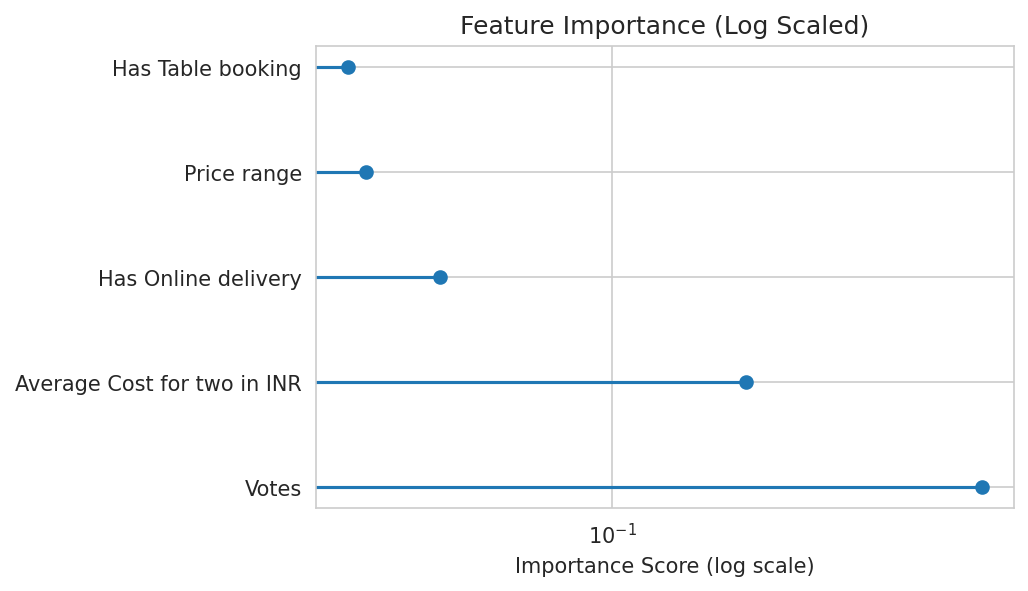

In [84]:
plt.figure(figsize=(6, 4))
plt.hlines(
    y=importances.index,
    xmin=0,
    xmax=importances.values
)
plt.plot(importances.values, importances.index, "o")
plt.xscale('log')
plt.xlabel("Importance Score (log scale)")
plt.title("Feature Importance (Log Scaled)")
plt.show()


## 9. Visibility and Trust Gap Analysis

Not all restaurants on the platform receive customer ratings.
A missing rating does not imply poor quality, but often indicates
low visibility or insufficient customer engagement.

In this section, we analyze how unrated restaurants differ from
rated ones across engagement, pricing, and geographic dimensions.


In [85]:
# Count rated vs unrated restaurants
visibility_counts = df['is_rated'].value_counts()
visibility_percent = df['is_rated'].value_counts(normalize=True) * 100

visibility_counts, visibility_percent

(is_rated
 1    7403
 0    2148
 Name: count, dtype: int64,
 is_rated
 1    77.510208
 0    22.489792
 Name: proportion, dtype: float64)

In [96]:
# Country level visibility gap
country_visibility = (
    df.groupby('Country')
    .apply(lambda x: (x['Aggregate rating'] == 0).mean() * 100)
    .reset_index(name='unrated_pct')
)

# Add representative coordinates per country
country_coords = (
    df.groupby('Country')
    .agg(lat=('Latitude', 'mean'), lon=('Longitude', 'mean'))
    .reset_index()
)

country_visibility = country_visibility.merge(country_coords, on='Country')

from branca.colormap import linear
import folium

# Create color scale
country_colormap = linear.OrRd_09.scale(
    country_visibility['unrated_pct'].min(),
    country_visibility['unrated_pct'].max()
)
country_colormap.caption = "Percentage of Unrated Restaurants"

# Base map
country_gap_map = folium.Map(
    location=[20, 0],
    zoom_start=2,
    tiles="CartoDB positron"
)

# Add bubbles
for _, row in country_visibility.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=row['unrated_pct'] * 1.5,
        fill=True,
        fill_color=country_colormap(row['unrated_pct']),
        fill_opacity=0.85,
        color=None,
        popup=f"""
        Country: {row['Country']}<br>
        Unrated %: {row['unrated_pct']:.1f}
        """
    ).add_to(country_gap_map)

country_colormap.add_to(country_gap_map)
country_gap_map

/tmp/ipython-input-2192213746.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['Aggregate rating'] == 0).mean() * 100)


In [99]:
india_df = df[df['Country'] == 'India'].copy()

india_df['is_unrated'] = (india_df['Aggregate rating'] == 0).astype(int)

# Define grid size
lat_bin = 0.5
lon_bin = 0.5

india_df['lat_bin'] = (india_df['Latitude'] // lat_bin) * lat_bin
india_df['lon_bin'] = (india_df['Longitude'] // lon_bin) * lon_bin

grid_visibility = (
    india_df
    .groupby(['lat_bin', 'lon_bin'])
    .agg(
        unrated_pct=('is_unrated', 'mean'),
        count=('Restaurant ID', 'count')
    )
    .reset_index()
)

# Convert to percentage
grid_visibility['unrated_pct'] *= 100

# Remove tiny cells to reduce noise
grid_visibility = grid_visibility[grid_visibility['count'] >= 10]

from branca.colormap import linear
import folium

colormap = linear.Reds_09.scale(
    grid_visibility['unrated_pct'].min(),
    grid_visibility['unrated_pct'].max()
)
colormap.caption = "Unrated Restaurants Percentage"

india_map = folium.Map(
    location=[22.5, 78.9],
    zoom_start=5,
    tiles="CartoDB positron"
)

for _, row in grid_visibility.iterrows():
    folium.Rectangle(
        bounds=[
            [row['lat_bin'], row['lon_bin']],
            [row['lat_bin'] + lat_bin, row['lon_bin'] + lon_bin]
        ],
        fill=True,
        fill_color=colormap(row['unrated_pct']),
        fill_opacity=0.8,
        color=None,
        popup=f"""
        Unrated %: {row['unrated_pct']:.1f}<br>
        Restaurants: {row['count']}
        """
    ).add_to(india_map)

colormap.add_to(india_map)
india_map


In [98]:
ncr_cities = ['New Delhi', 'Gurgaon', 'Noida', 'Faridabad', 'Ghaziabad']

ncr_df = df[
    (df['Country'] == 'India') &
    (df['City'].isin(ncr_cities))
].copy()

ncr_visibility = (
    ncr_df
    .groupby('City')
    .apply(lambda x: (x['Aggregate rating'] == 0).mean() * 100)
    .reset_index(name='unrated_pct')
)

coords = (
    ncr_df
    .groupby('City')
    .agg(lat=('Latitude', 'mean'), lon=('Longitude', 'mean'))
    .reset_index()
)

ncr_visibility = ncr_visibility.merge(coords, on='City')


from branca.colormap import linear
import folium

colormap = linear.Reds_09.scale(
    ncr_visibility['unrated_pct'].min(),
    ncr_visibility['unrated_pct'].max()
)
colormap.caption = "Unrated Restaurants (%)"

ncr_map = folium.Map(
    location=[28.5, 77.2],
    zoom_start=10,
    tiles="CartoDB positron"
)

for _, row in ncr_visibility.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=25,
        fill=True,
        fill_color=colormap(row['unrated_pct']),
        fill_opacity=0.85,
        color='black',
        weight=1,
        popup=f"""
        City: {row['City']}<br>
        Unrated %: {row['unrated_pct']:.1f}
        """
    ).add_to(ncr_map)

    folium.Marker(
        location=[row['lat'], row['lon']],
        icon=folium.DivIcon(
            html=f"""
            <div style="
                color: black;
                font-size: 12px;
                font-weight: bold;
                text-align: center;
            ">
                {row['City']}<br>
                {row['unrated_pct']:.1f}%
            </div>
            """
        )
    ).add_to(ncr_map)

colormap.add_to(ncr_map)
ncr_map

/tmp/ipython-input-3626478754.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['Aggregate rating'] == 0).mean() * 100)


### Engagement Comparison: Rated vs Unrated Restaurants

Votes represent customer engagement.
We compare vote distribution between rated and unrated restaurants
to understand whether unrated restaurants suffer from low visibility.

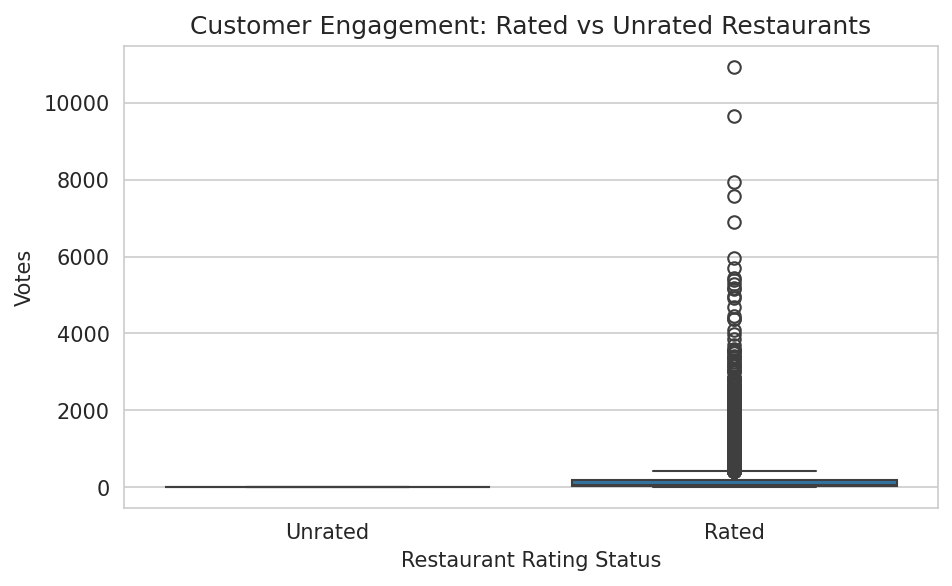

In [87]:
plt.figure(figsize=(7,4))
sns.boxplot(
    x='is_rated',
    y='Votes',
    data=df
)
plt.xticks([0,1], ['Unrated', 'Rated'])
plt.xlabel('Restaurant Rating Status')
plt.ylabel('Votes')
plt.title('Customer Engagement: Rated vs Unrated Restaurants')
plt.show()

### Pricing Characteristics of Unrated Restaurants

We analyze whether unrated restaurants are concentrated
in specific price ranges or cost bands.

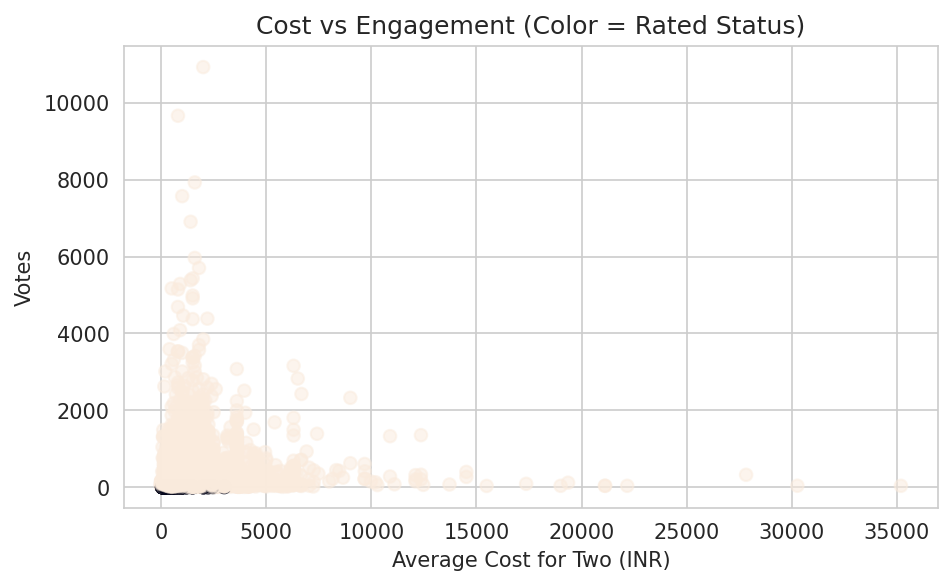

In [88]:
plt.figure(figsize=(7,4))
plt.scatter(
    df['Average Cost for two in INR'],
    df['Votes'],
    c=df['is_rated'],
    alpha=0.5
)
plt.xlabel('Average Cost for Two (INR)')
plt.ylabel('Votes')
plt.title('Cost vs Engagement (Color = Rated Status)')
plt.show()

### City-Level Visibility Gap

Some cities may have a higher concentration of unrated restaurants,
indicating regional discovery or onboarding issues.

In [89]:
city_visibility = (
    df.groupby('City')['is_rated']
    .apply(lambda x: (x == 0).mean() * 100)
    .sort_values(ascending=False)
)

city_visibility.head(10)

,is_rated
City,
Faridabad,39.840637
Noida,35.555556
New Delhi,26.036908
Gurgaon,20.393560
Sí£o Paulo,15.000000
Davenport,10.000000
Ghaziabad,8.000000
Birmingham,5.000000
Pocatello,5.000000


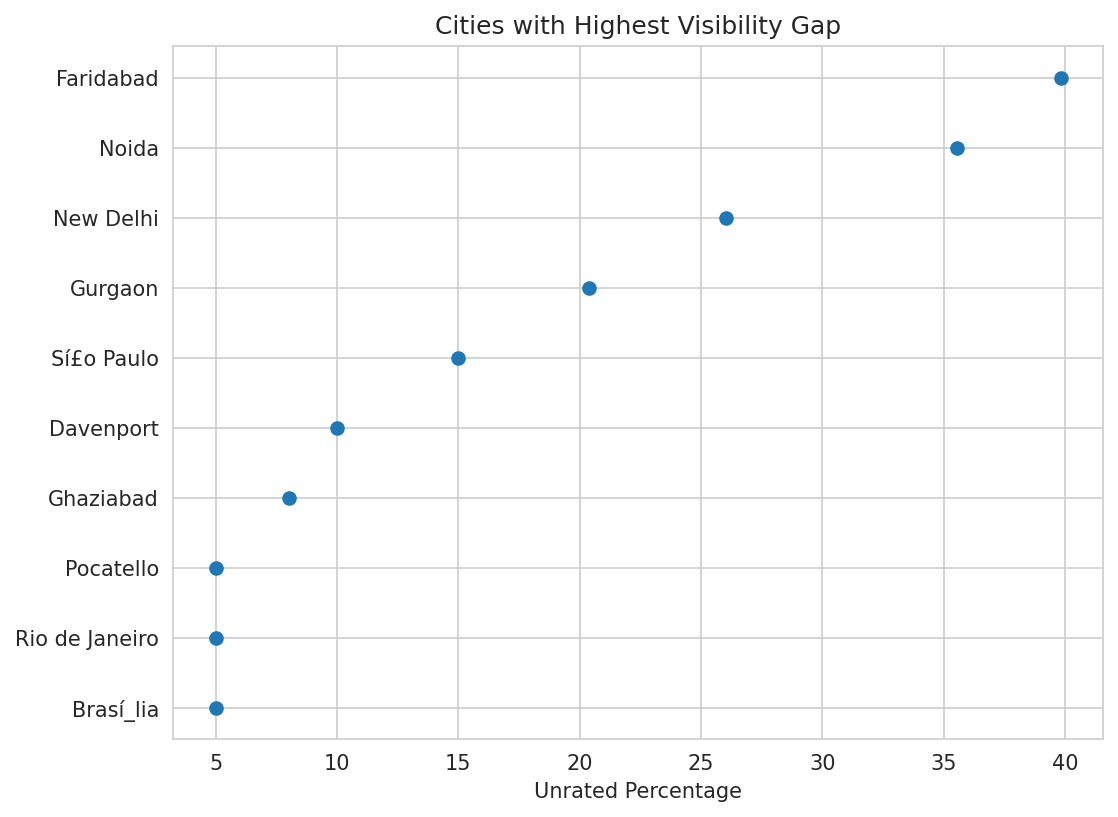

In [90]:
top_gap = visibility_gap.sort_values(
    'unrated_pct',
    ascending=True
).tail(10)

plt.figure(figsize=(8, 6))
plt.scatter(
    top_gap['unrated_pct'],
    top_gap['City']
)

plt.xlabel("Unrated Percentage")
plt.title("Cities with Highest Visibility Gap")
plt.show()

## Visibility and Trust Gap – Key Findings

Our analysis reveals a significant visibility gap on the Foodora Eats platform.

### Scale of the Visibility Gap
- **22.5% of restaurants are unrated** (2148 out of 9551).
- This is a substantial portion of the supply-side ecosystem and cannot be ignored.
- Unrated does not mean low quality, but indicates lack of customer interaction or visibility.

---

### Engagement Difference: Rated vs Unrated Restaurants
- The boxplot comparison of votes shows a **sharp contrast** between rated and unrated restaurants.
- **Unrated restaurants have near-zero votes**, while rated restaurants show a wide distribution with very high engagement.
- This confirms that ratings are strongly linked to customer engagement rather than pricing or quality alone.

**Insight:**  
Unrated restaurants suffer primarily from **low exposure**, not necessarily poor performance.

---

### Cost vs Engagement Analysis
- Scatter analysis of cost versus votes shows that **unrated restaurants are spread across all cost bands**.
- Both budget and premium restaurants appear in the unrated category.
- There is no clear price-based exclusion effect.

**Insight:**  
Lack of ratings is **not driven by affordability or pricing**. Visibility and discovery mechanisms are the root cause.

---

### City-Level Visibility Gap
Several cities exhibit a **disproportionately high share of unrated restaurants**:

- **Faridabad:** ~40% unrated
- **Noida:** ~35% unrated
- **New Delhi:** ~26% unrated
- **Gurgaon:** ~20% unrated

These cities also have high restaurant density, indicating that competition may be diluting visibility.

**Insight:**  
High-activity cities are facing **discovery saturation**, where many restaurants fail to receive sufficient exposure despite strong demand.

---

### Business Interpretation
- Ratings act as a **trust signal** on the platform.
- Restaurants without ratings are effectively invisible to users.
- The visibility gap is **geographically concentrated**, not random.

This points to an opportunity for Foodora Eats to:
- Improve onboarding and early exposure for new restaurants
- Introduce city-specific discovery boosts
- Encourage first reviews in high-gap cities

This insight forms a strong foundation for targeted platform-level interventions.

## 10. Popularity vs Satisfaction Mismatch (Cuisine-Level)

## Popularity vs Satisfaction Analysis (Cuisine-Level)

Popularity does not always imply quality.
Some cuisines attract many restaurants and customers but fail to
deliver consistent satisfaction.

In this section, we compare cuisine popularity against customer
satisfaction to identify:
- Overrepresented but underperforming cuisines
- High-quality niche cuisines that deserve more visibility

In [91]:
# Cuisine-level summary
cuisine_summary = (
    df_cuisine
    .groupby('Cuisines')
    .agg(
        restaurant_count=('Restaurant ID', 'count'),
        avg_rating=('Aggregate rating', 'mean'),
        avg_votes=('Votes', 'mean')
    )
    .reset_index()
)

# Focus on cuisines with sufficient presence
cuisine_summary = cuisine_summary[cuisine_summary['restaurant_count'] >= 30]

cuisine_summary.sort_values('restaurant_count', ascending=False).head(10)

,Cuisines,restaurant_count,avg_rating,avg_votes
100,North Indian,3960,2.510455,150.500253
34,Chinese,2735,2.621024,133.217916
49,Fast Food,1986,2.563092,92.677744
95,Mughlai,995,2.609950,152.709548
70,Italian,764,3.562042,430.975131
13,Bakery,745,2.440940,77.444295
37,Continental,736,3.518750,391.650815
27,Cafe,703,3.321195,252.586060
42,Desserts,653,2.978867,162.157734
123,South Indian,636,2.469811,127.298742


### Popularity vs Satisfaction Mapping

Each cuisine is positioned based on:
- Number of restaurants offering it (popularity)
- Average customer rating (satisfaction)

This helps identify mismatches between demand and quality.

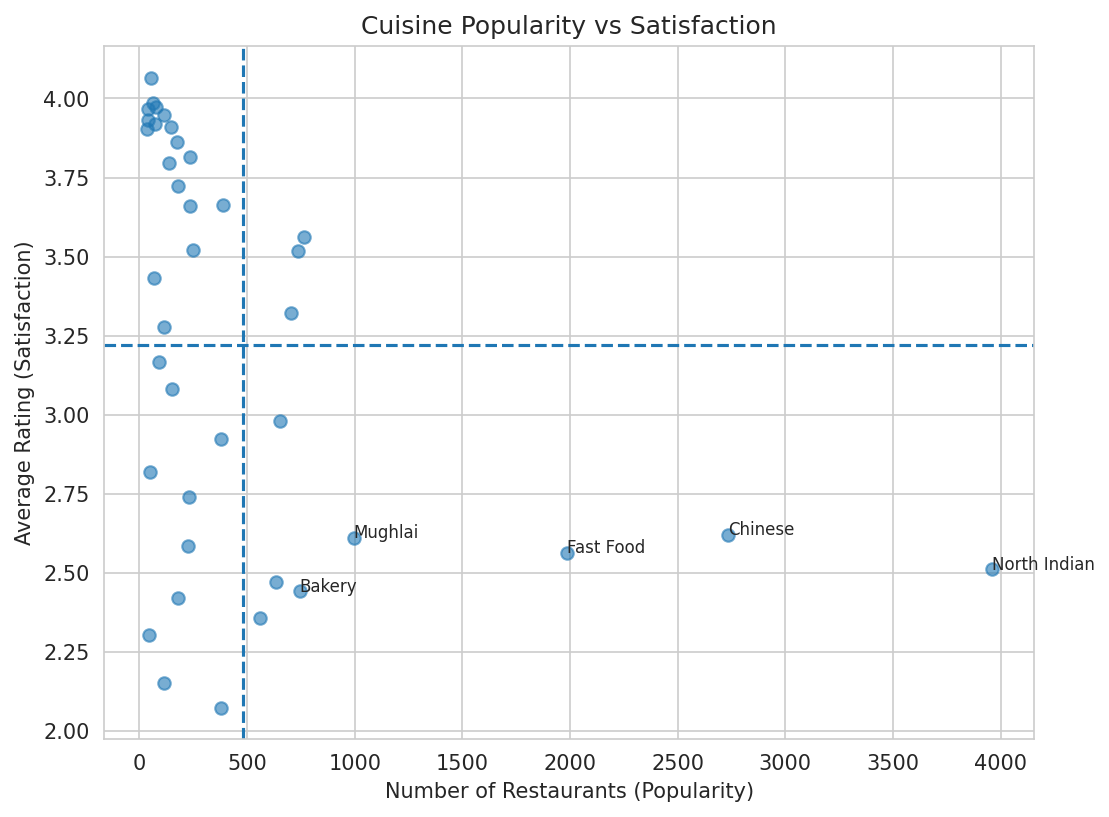

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(
    cuisine_summary['restaurant_count'],
    cuisine_summary['avg_rating'],
    alpha=0.6
)

plt.axhline(cuisine_summary['avg_rating'].mean(), linestyle='--')
plt.axvline(cuisine_summary['restaurant_count'].mean(), linestyle='--')

plt.xlabel('Number of Restaurants (Popularity)')
plt.ylabel('Average Rating (Satisfaction)')
plt.title('Cuisine Popularity vs Satisfaction')

for _, row in cuisine_summary.iterrows():
    if row['restaurant_count'] > cuisine_summary['restaurant_count'].quantile(0.85) and row['avg_rating'] < cuisine_summary['avg_rating'].mean():
        plt.text(row['restaurant_count'], row['avg_rating'], row['Cuisines'], fontsize=8)

plt.show()

### High-Risk Cuisines

Cuisines with high popularity but below-average ratings pose a
platform risk, as they:
- Dominate discovery surfaces
- Reduce perceived platform quality
- Increase customer dissatisfaction

In [93]:
high_risk_cuisines = cuisine_summary[
    (cuisine_summary['restaurant_count'] > cuisine_summary['restaurant_count'].mean()) &
    (cuisine_summary['avg_rating'] < cuisine_summary['avg_rating'].mean())
].sort_values('restaurant_count', ascending=False)

high_risk_cuisines[['Cuisines', 'restaurant_count', 'avg_rating']].head(10)

,Cuisines,restaurant_count,avg_rating
100,North Indian,3960,2.510455
34,Chinese,2735,2.621024
49,Fast Food,1986,2.563092
95,Mughlai,995,2.609950
13,Bakery,745,2.440940
42,Desserts,653,2.978867
123,South Indian,636,2.469811
129,Street Food,562,2.356050


### High-Quality Niche Cuisines (Hidden Gems)

Some cuisines receive fewer listings but consistently high ratings.
These cuisines represent an opportunity for:
- Promotion
- Editorial discovery
- Premium positioning

In [94]:
hidden_gems = cuisine_summary[
    (cuisine_summary['restaurant_count'] < cuisine_summary['restaurant_count'].mean()) &
    (cuisine_summary['avg_rating'] > cuisine_summary['avg_rating'].mean())
].sort_values('avg_rating', ascending=False)

hidden_gems[['Cuisines', 'restaurant_count', 'avg_rating']].head(10)

,Cuisines,restaurant_count,avg_rating
116,Sandwich,53,4.066038
128,Steak,62,3.985484
131,Sushi,75,3.973333
21,Breakfast,41,3.965854
87,Mediterranean,112,3.948214
14,Bar Food,39,3.933333
65,Indian,70,3.918571
48,European,148,3.910811
12,BBQ,33,3.903030
118,Seafood,174,3.862069


### Engagement Validation Using Votes

To validate whether customer engagement aligns with satisfaction,
we compare votes across cuisine categories.

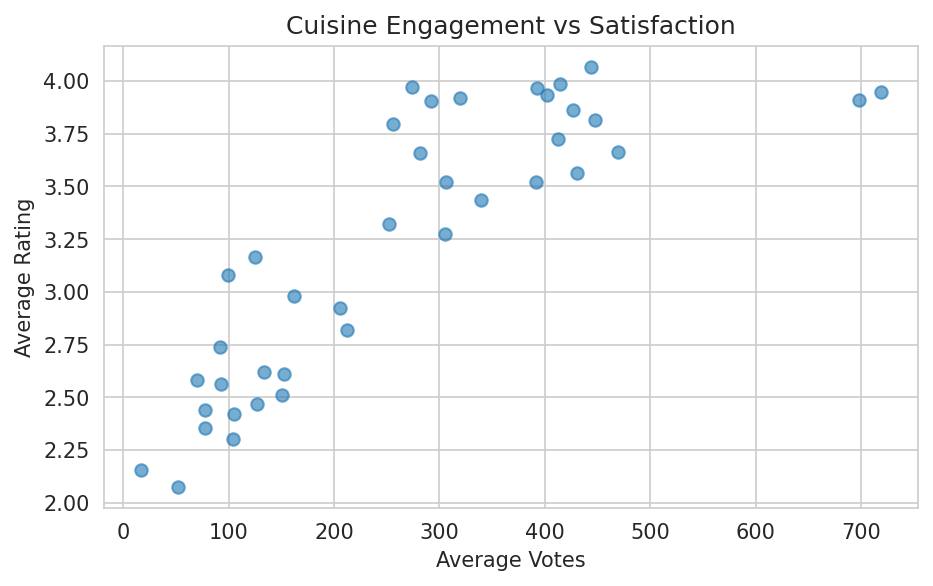

In [95]:
plt.figure(figsize=(7,4))
plt.scatter(
    cuisine_summary['avg_votes'],
    cuisine_summary['avg_rating'],
    alpha=0.6
)
plt.xlabel('Average Votes')
plt.ylabel('Average Rating')
plt.title('Cuisine Engagement vs Satisfaction')
plt.show()

## Popularity vs Satisfaction – Key Business Insights (Cuisine-Level)

Our analysis reveals a clear mismatch between cuisine popularity and
customer satisfaction on the Foodora Eats platform.

### 1. High Popularity, Low Satisfaction Cuisines (Quality Risk)

The most widely offered cuisines on the platform have **below-average ratings**:

- **North Indian**  
  - ~3960 restaurants  
  - Average rating: ~2.51  

- **Chinese**  
  - ~2735 restaurants  
  - Average rating: ~2.62  

- **Fast Food**  
  - ~1986 restaurants  
  - Average rating: ~2.56  

- **Mughlai**  
  - ~995 restaurants  
  - Average rating: ~2.61  

- **Bakery**  
  - ~745 restaurants  
  - Average rating: ~2.44  

These cuisines dominate discovery surfaces but consistently underperform
in customer satisfaction.

**Insight:**  
Foodora Eats is currently overexposing cuisines that deliver
inconsistent or below-average experiences, which can negatively impact
overall platform perception.

---

### 2. High Quality, Lower Visibility Cuisines (Growth Opportunity)

Several cuisines show **high customer satisfaction but relatively lower presence**:

- **Sandwich** – Avg rating ~4.06  
- **Steak** – Avg rating ~3.99  
- **Sushi** – Avg rating ~3.97  
- **Breakfast** – Avg rating ~3.96  
- **Mediterranean** – Avg rating ~3.95  
- **European** – Avg rating ~3.91  
- **BBQ** – Avg rating ~3.90  
- **Seafood** – Avg rating ~3.86  

These cuisines consistently score well but are underrepresented.

**Insight:**  
These cuisines represent “hidden gems” that Foodora Eats can promote
to improve perceived quality without expanding inventory.

---

### 3. Engagement Confirms Satisfaction Patterns

The engagement vs satisfaction plot shows that:
- Cuisines with higher average ratings generally attract **higher average votes**
- Low-rated popular cuisines also show **weaker engagement efficiency**

**Insight:**  
Customer engagement reinforces the satisfaction gap and validates that
this is not a statistical artifact.

---

### 4. Strategic Implications

- Popularity should not be the sole driver of ranking and promotion.
- Cuisine-aware curation can significantly improve user trust.
- Promoting high-quality niche cuisines can elevate platform reputation
  without increasing supply.

This insight directly informs ranking algorithms, homepage curation,
and cuisine-based campaigns.


## 11. Limitations & Assumptions

## Limitations and Assumptions

While the analysis provides strong directional insights, it is important
to acknowledge certain limitations:

- The dataset does not include a time dimension, so trends over time
  and seasonality could not be analyzed.
- Ratings are user-generated and may contain bias based on review volume
  and customer expectations.
- Some cuisines and localities have low representation, which may lead
  to higher variance in average ratings.
- Currency conversion uses static exchange rates and does not reflect
  historical or real-time fluctuations.
- The modeling exercise is exploratory and intended for feature
  importance, not production-grade prediction.

These factors should be considered when translating insights into
product or policy decisions.

## 12. Business Action Mapping

## Insight to Action Mapping

The analysis directly translates into actionable opportunities
for Foodora Eats:

- **Visibility Gap**  
  → Introduce first-review incentives and discovery boosts for unrated
    restaurants in high-gap cities.

- **Cuisine Quality Mismatch**  
  → Reduce over-promotion of low-rated popular cuisines and surface
    high-quality niche cuisines.

- **City-Level Inconsistency**  
  → Apply locality-level quality monitoring instead of city-wide policies.

- **Delivery Impact**  
  → Focus delivery expansion on cuisines and cities where engagement
    gains are strongest.

- **Pricing Insights**  
  → Optimize recommendations around mid-priced restaurants that balance
    affordability and satisfaction.

These actions can improve customer trust, restaurant success,
and platform engagement simultaneously.


## 13. “If I Had More Data”

## Future Analysis Opportunities

With additional data, the following extensions would further
strengthen insights:

- Time-based analysis of rating evolution and restaurant lifecycle.
- User-level behavior to study repeat visits and loyalty.
- Text analysis of reviews to identify qualitative drivers of ratings.
- A/B testing impact of cuisine-based and locality-based promotions.
- Survival analysis to understand restaurant churn risk.

These extensions would enable more personalized and predictive
decision-making.

# Final Summary and Readiness

This notebook translated cleaned restaurant data into actionable
business insights for the Foodora Eats platform.

Key outcomes include:

- Identified a significant **visibility and trust gap**, with over
  22% of restaurants remaining unrated due to low customer engagement
  rather than poor quality.
- Discovered a clear **mismatch between cuisine popularity and customer
  satisfaction**, where highly promoted cuisines underperform while
  niche cuisines deliver consistently higher ratings.
- Highlighted **city and locality-level performance disparities**,
  showing that high restaurant density does not guarantee quality
  consistency.
- Demonstrated that **delivery and booking availability improve
  engagement more than satisfaction**, indicating operational rather
  than experiential impact.
- Established that **votes, pricing, and service availability** are
  strong drivers of restaurant ratings, validated through both
  exploratory analysis and baseline modeling.

The analysis provides Foodora Eats with a strong foundation to improve
restaurant discovery, optimize promotion strategies, and enhance
customer trust.

This notebook is analysis-complete and recommendation-ready.
